## Init

In [1]:
from cosmoslik import *
from getdist import MCSamples
import dill as pickle
import wquantiles
from planck_reio3 import planck
from matplotlib.colors import to_rgb
from matplotlib.patches import Patch
from functools import partial

In [2]:
# from imp import reload
# import planck_reio3
# reload(planck_reio3)
# from planck_reio3 import *

In [3]:
def getτprior(c, k="cosmo.tau_out", ranges=None, smooth=0.1):
    d = MCSamples(samples=c[k], weights=c['weight'], 
                  names=['x'], ranges=({'x':ranges} if ranges else None),
                  settings={'smooth_scale_1D':(smooth or -1)}).get1DDensity(0)
    return lambda τ: d.Prob(τ)[0]

def flatτ(c, Pτ, k="cosmo.tau_out", maxweight=10000):
    origweight = c['weight'].sum()
    Z = getattr(c,"Z",None)
    c = c.reweighted(lambda **kw: min(maxweight,1/Pτ(kw[k])))
    c['weight'] *= origweight/c['weight'].sum()
    if Z: c.Z=Z
    return c

In [4]:
def getZ(s,force=False):
    if not force and "Still Active" in open(s).read():
        return [nan,nan]
    else:
        return array(array(open(s).readlines()[8].split())[[2,4]],float)

In [5]:
def load_polychord(filename,Z0=0):
    c = load_cosmomc_chain(filename+'.txt')
    c.Z, c.σZ = getZ(filename+'.stats',force=True)
    c["weight"]/=(c["weight"].sum()*exp(-(c.Z-Z0)))
    return c

In [6]:
τmin_gp = 0.0385
τmin_tanh_gp = 0.043

## $\tau$ priors figure

### Stuff for analytic prior and post-processing 

In [7]:
sk = Slik(planck(modesfile="mh_xepcs_raw.dat",model="reiomodes_fixclamp",nmodes=10,no_clik=True,mhprior='cube_sphere',mhfid=True,mhfidbase=0.54))
_,p = sk.evaluate(**sk.get_start())
τfid = p.cosmo.tau_out
Δm = 0.1
dτ_dmᵢ = array([diff([sk.evaluate(**dict(sk.get_start(),**{"cosmo.reiomodes.mode%i"%i:x*Δm}))[1].cosmo.tau_out for x in [-1,1]])[0]/(2*Δm) for i in range(20)])
r = 1.08/2

In [8]:
sk.params.camb.mplus

array([0.44629507, 0.47761742, 0.48146497, 0.47204077, 0.4517857 ,
       0.47580438, 0.47968557, 0.48955218, 0.49053275, 0.47966642,
       0.46303673, 0.47777039, 0.48581736, 0.47449012, 0.4618197 ,
       0.47718273, 0.49430312, 0.52374602, 0.47460559, 0.47617728,
       0.46966004, 0.49324062, 0.58693997, 0.55784276, 0.48451482,
       0.47218646, 0.53523031, 0.49148546, 0.49188205, 0.48604483,
       0.52417701, 0.52285791, 0.52451977, 0.51884676, 0.49743133,
       0.50226191, 0.58631606, 0.53257958, 0.53551704, 0.5726018 ,
       0.50874662, 0.54438058, 0.58017886, 0.54630694, 0.52558106,
       0.5275767 , 0.53781624, 0.50853147, 0.55088261, 0.52501795,
       0.54899919, 0.50982187, 0.50228612, 0.54066688, 0.56676312,
       0.51749911, 0.51223345, 0.58203733, 0.5308159 , 0.51600059,
       0.57452384, 0.56320937, 0.55437509, 0.5515784 , 0.53337137,
       0.57904727, 0.55196519, 0.50956941, 0.56063133, 0.53032483,
       0.55736925, 0.56915486, 0.5810763 , 0.58598983, 0.51842

In [9]:
dτ_dmᵢ[:3]

array([ 0.29901602, -0.1102962 ,  0.05831463])

In [10]:
@vectorize
def Pτ_modes2_op_analytic_m1cube(τ):
    n = 2
    d = abs(τ-τfid)/norm(dτ_dmᵢ[:n])
    θ = arccos(dτ_dmᵢ[0]/norm(dτ_dmᵢ[:n]))
    r = sk.params.camb.radius
    h = sk.params.camb.mplus[0]
    
#     return (h*cos(θ) + sqrt(r**2-h**2)*sin(θ)), d,  (h*cos(θ) - sqrt(r**2-h**2)*sin(θ))
    
    if d < (h*cos(θ) - sqrt(r**2-h**2)*sin(θ)):
        return 2*sqrt(r**2 - d**2) / (2*r)
    elif (h*cos(θ) + sqrt(r**2-h**2)*sin(θ)) > d > (h*cos(θ) - sqrt(r**2-h**2)*sin(θ)):
        return (sqrt(r**2 - d**2) + (h/sin(θ) - d*cos(θ)/sin(θ))) / (2*r)
    else:
        return 0.

In [11]:
@vectorize
def Pτ_modes3_op_analytic_m1cube(τ):
    n = 3
    d = abs(τ-τfid)/norm(dτ_dmᵢ[:n])
    θ = arccos(dτ_dmᵢ[0]/norm(dτ_dmᵢ[:n]))
    r = sk.params.camb.radius
    h = sk.params.camb.mplus[0]
    
    hp = h/sin(θ) - d*cos(θ)/sin(θ)
    ϕ = arccos(hp/r)
#     print(r,hp)

    
    if d < (h*cos(θ) - sqrt(r**2-h**2)*sin(θ)):
        return pi*(r**2 - d**2) / (pi*r**2)
    elif (h*cos(θ) + sqrt(r**2-h**2)*sin(θ)) > d > (h*cos(θ) - sqrt(r**2-h**2)*sin(θ)):
        return (pi*(r**2 - d**2) - r**2/2*(ϕ-sin(ϕ))) / (pi*r**2)
    else:
        return 0.

In [52]:
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


In [13]:
cmodes_op_noclik[2].like1d("cosmo.tau_out", maxed=True, kde=True, c="C0", smooth=0.1)
plot(τs,Pτ_modes2_op_analytic_m1cube(τs), "C0--")

cmodes_op_noclik[3].like1d("cosmo.tau_out", maxed=True, kde=True, c="C1", smooth=0.1)
plot(τs,Pτ_modes3_op_analytic_m1cube(τs), "C1--")
plot(τs,Pτ_modes_op_analytic[3](τs), "C1:")

ylim(0,1)

NameError: name 'cmodes_op_noclik' is not defined

In [66]:
c2=cmodes_op_noclik[3]

In [69]:
c2=cmodes5_simlow_op

In [73]:
from mpl_toolkits.mplot3d import Axes3D

In [84]:
%matplotlib notebook

In [100]:
r

0.54

<IPython.core.display.Javascript object>


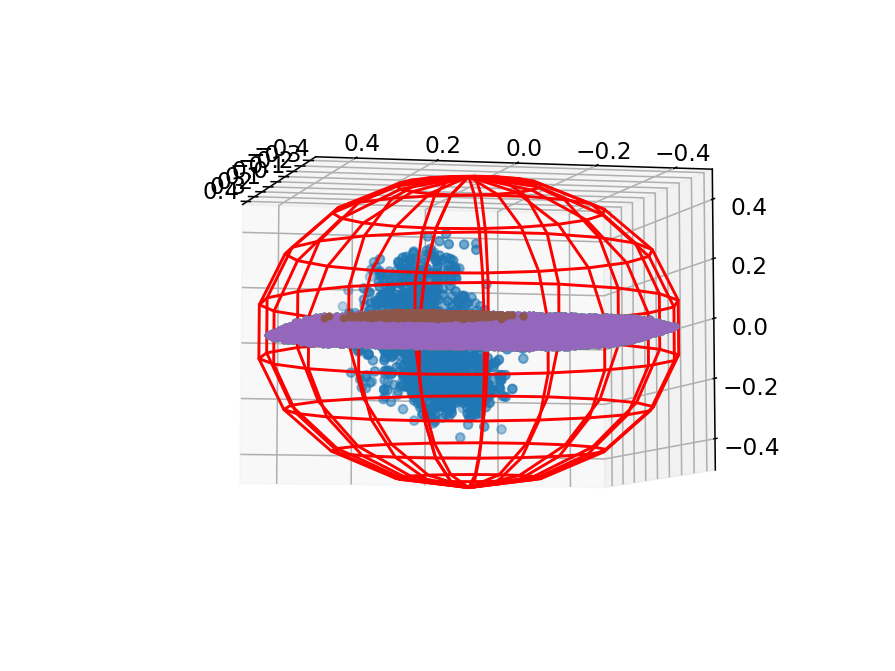

(-0.48333668695354853, 0.48146497110011754)

In [101]:
c=cmodes_op_noclik[3].thinto(10000)
c2=cmodes5_simlow_op.thinto(1000)

ax=subplot(projection='3d')
# ax.scatter(c["cosmo.reiomodes.mode0"],c["cosmo.reiomodes.mode1"],c["cosmo.reiomodes.mode2"],alpha=0.2)
ax.scatter(c2["cosmo.reiomodes.mode0"],c2["cosmo.reiomodes.mode1"],c2["cosmo.reiomodes.mode2"])

# draw sphere
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x = r*np.cos(u)*np.sin(v)
y = r*np.sin(u)*np.sin(v)
z = r*np.cos(v)
ax.plot_wireframe(x, y, z, color="r")


ax.set_xlim3d(sk.params.camb.mminus[0],sk.params.camb.mplus[0])
ax.set_ylim3d(sk.params.camb.mminus[1],sk.params.camb.mplus[1])
ax.set_zlim3d(sk.params.camb.mminus[2],sk.params.camb.mplus[2])

In [207]:
cmodes_op_noclik_sphere = {5:load_chain("chains/chain_reiomodes_fixclamp_nmodes5_noclik_mh_xepcs_raw_mhpriorcubesphere_mhfid_mhfidbase054_hardxe100200_cube2").join()}

In [200]:
c2=cmodes_op_noclik_sphere[5]
c=cmodes_op_noclik[5]

(0, 0.4)

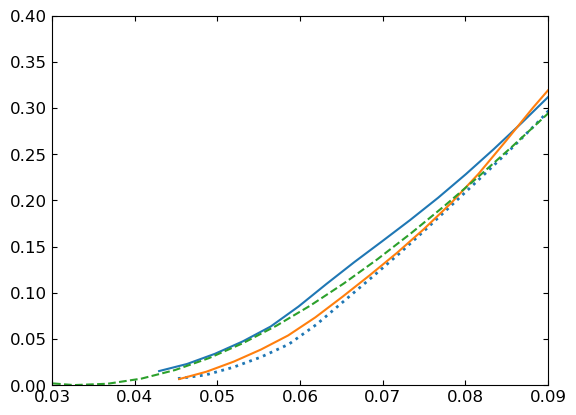

In [213]:
cmodes_op_noclik_sphere[5].like1d("cosmo.tau_out",maxed=True,kde=False,smooth=0.1)

cmodes_op_noclik_sphere[5].sample(cmodes_op_noclik_sphere[5]["cosmo.reiomodes.mode0"]>sk.params.camb.mminus[0]).like1d("cosmo.tau_out",c="C0",ls=":",lw=2,maxed=True,kde=False,smooth=0.1)

cmodes_op_noclik[5].like1d("cosmo.tau_out",maxed=True,smooth=0.1,kde=False)
plot(τs,Pτ_modes_op_analytic[5](τs),"--")

xlim(0.03,0.09)
ylim(0,0.4)

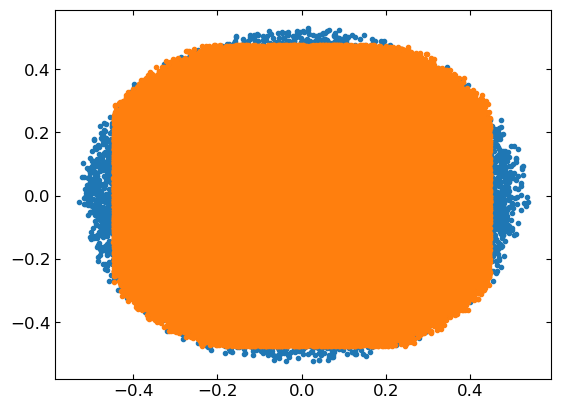

In [202]:
scatter(c2["cosmo.reiomodes.mode0"],c2["cosmo.reiomodes.mode1"],marker=".")
scatter(c["cosmo.reiomodes.mode0"],c["cosmo.reiomodes.mode1"],marker=".")

In [ ]:
scatter()

In [205]:
c=cmodes_op_noclik[5].thinto(100000)

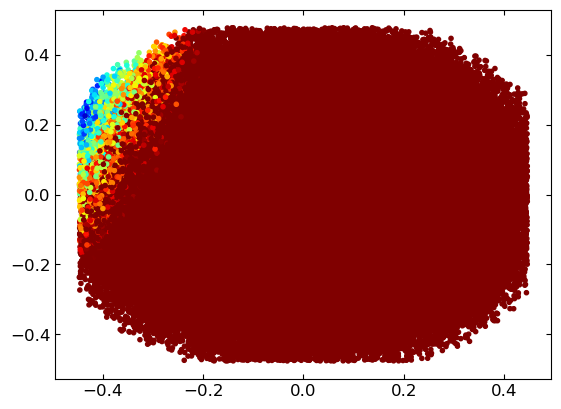

In [206]:
scatter(c["cosmo.reiomodes.mode0"],c["cosmo.reiomodes.mode1"],c=c["cosmo.tau_out"],marker=".",cmap="jet",vmin=0.038, vmax=0.09)

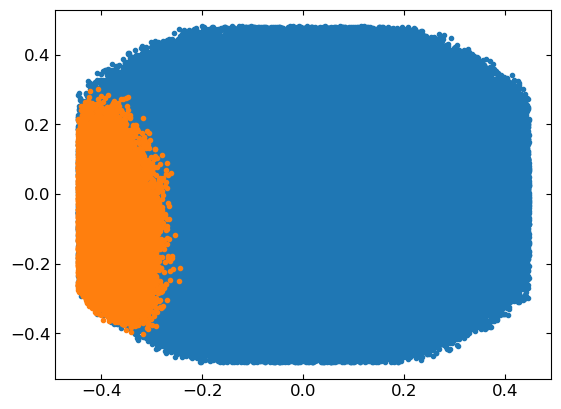

In [109]:
c=cmodes_op_noclik[5]
c2=cmodes5_simlow_op

plot(c["cosmo.reiomodes.mode0"],c["cosmo.reiomodes.mode2"],".")
plot(c2["cosmo.reiomodes.mode0"],c2["cosmo.reiomodes.mode2"],".")

In [137]:
 0.54/sk.params.camb.mplus[:5]

array([ 1.20996183,  1.13061202,  1.12157692,  1.143969  ,  1.19525696])

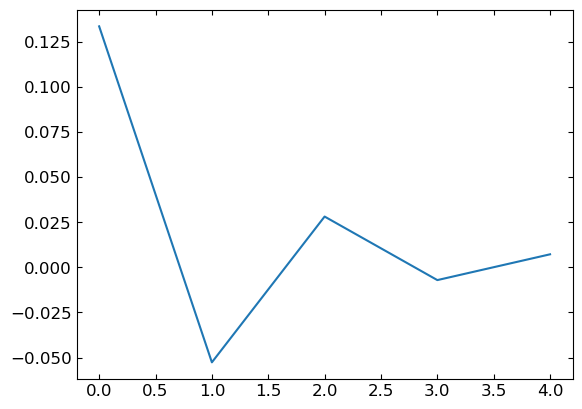

In [41]:
plot(dτ_dmᵢ[:5] * sk.params.camb.mplus[:5])

Used for $\tau(15,z_{\rm max})$ calculation, and note mhfidbase=0.15 here:

In [17]:
sk = Slik(load_script('planck_reio3.py')[1](
    modesfile="mh_xepcs_raw.dat",model="reiomodes_fixclamp",nmodes=10,no_clik=True,mhprior='cube_sphere',mhfid=True,mhfidbase=0.15))
sk.params.camb.zmin_cut=15
_,p = sk.evaluate(**sk.get_start())
τ15fid = p.cosmo.tau_out
Δm = 0.1
dτ15_dmᵢ = array([diff([sk.evaluate(**dict(sk.get_start(),**{"cosmo.reiomodes.mode%i"%i:x*Δm}))[1].cosmo.tau_out for x in [-1,1]])[0]/(2*Δm) for i in range(20)])
r = 1.08/2

In [18]:
sk = Slik(load_script('planck_reio3.py')[1](
    modesfile="mh_xepcs_raw.dat",model="reiomodes_fixclamp",nmodes=10,no_clik=True,mhprior='cube_sphere',mhfid=True,mhfidbase=0.54))
sk.params.camb.zmin_cut=15
_,p = sk.evaluate(**sk.get_start())
τ15opfid = p.cosmo.tau_out
Δm = 0.1
dτ15op_dmᵢ = array([diff([sk.evaluate(**dict(sk.get_start(),**{"cosmo.reiomodes.mode%i"%i:x*Δm}))[1].cosmo.tau_out for x in [-1,1]])[0]/(2*Δm) for i in range(20)])
r = 1.08/2

### Load chains

In [14]:
cmodes_noclik = {i:load_chain("chains/chain_reiomodes_fixclamp_nmodes%i_noclik_mhprior_mhfid_mh_xepcs_raw_hardxe100200"%i).join() 
                 for i in range(1,8)}

In [19]:
cmodes_op_noclik = {i: load_chain("chains/chain_reiomodes_fixclamp_nmodes%i_noclik_mh_xepcs_raw_mhpriorcubesphere_mhfid_mhfidbase054_hardxe100200"%i).join()
                    for i in range(1,8)}

cmodes_noclik[5]['cosmo.tau15'] = τ15fid + dot(array([cmodes_noclik[5]['cosmo.reiomodes.mode%i'%i] for i in range(5)]).T, dτ15_dmi[:5])
cmodes_op_noclik[5]['cosmo.tau15'] = τ15opfid + dot(array([cmodes_op_noclik[5]['cosmo.reiomodes.mode%i'%i] for i in range(5)]).T, dτ15op_dmi[:5])

In [20]:
cknots_noclik = load_chain("chains/chain_reioknots_fixclamp_knots_6_7.5_10_20_noclik_gpprior_reiotau_xepcs_v3").burnin(2000).join()

In [21]:
cflex_noclik = {i:load_chain("chains/chain_reioflexknots2_fixclamp_nmodes%i_noclik_gpprior"%i).join() for i in range(1,6)}

### Compute tau priors and save "undone" runs

In [22]:
τs = linspace(0,0.2)

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


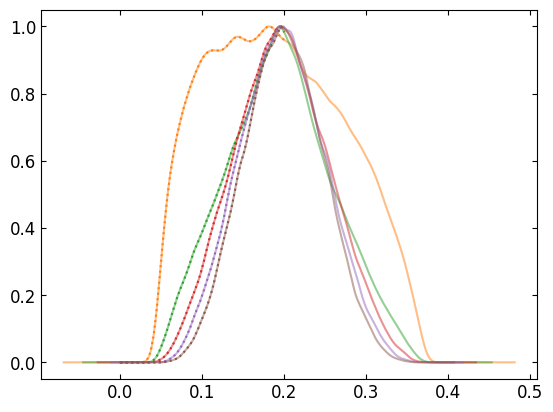

In [25]:
Pτ_flex = {}
for i,c in cflex_noclik.items():
    Pτ = Pτ_flex[i] = getτprior(c)
    c.like1d("cosmo.tau_out",maxed=True, smooth=0.1, c="C%i"%i, alpha=0.5)
    plot(τs, vectorize(Pτ)(τs), "C%i:"%i)
    with open("taupriors/reioflexknots_nmodes%i.dat"%i,"wb") as f:
        pickle.dump(Pτ,f)

Removed no burn in
Removed no burn in


/home/marius/work/cosmoslik/cosmoslik/chains.py:478: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  H, xe = histogram(dat,bins=nbins,weights=weights,normed=True,range=ranges)
/home/marius/work/cosmoslik/cosmoslik/chains.py:479: MatplotlibDeprecationWarning: The movavg function was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  xem=movavg(xe,2)


Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


(0, 0.4)

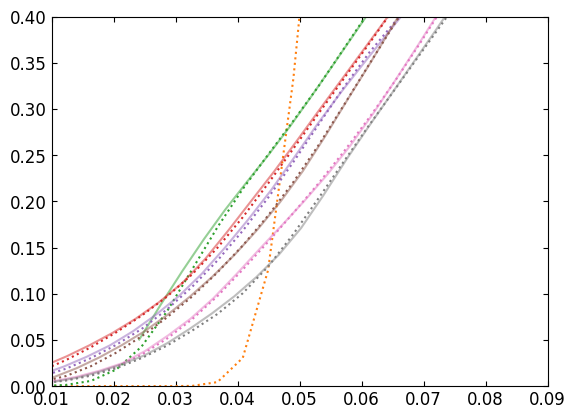

In [26]:
Pτ_modes = {}
for i,c in cmodes_noclik.items():
    Pτ = Pτ_modes[i] = getτprior(c)
    c.like1d("cosmo.tau_out",maxed=True, smooth=0.1, c="C%i"%i, alpha=0.5, kde=False)
    plot(τs, vectorize(Pτ)(τs), "C%i:"%i)
    with open("taupriors/mh_xepcs_nmodes%i.dat"%i,"wb") as f:
        pickle.dump(Pτ,f)
xlim(0.01, 0.09)
ylim(0,0.4)

In [27]:
cmodes_op_noclik[5]

               # of steps:  366500
             total weight:  366500.00
               acceptance:  1
                 cosmo.H0:       66.81 ± 1.421e-14
    cosmo.reiomodes.mode0:   -0.001056 ± 0.203
    cosmo.reiomodes.mode1:     0.00257 ± 0.2082
    cosmo.reiomodes.mode2:   -0.006958 ± 0.2058
    cosmo.reiomodes.mode3:     0.01002 ± 0.1972
    cosmo.reiomodes.mode4:    -0.01834 ± 0.1861
              cosmo.tau15:      0.1188 ± 0.05728
          cosmo.tau15_out:      0.1203 ± 0.05726
            cosmo.tau_out:      0.2079 ± 0.06608
               lnls.highl:           0 ± 0
       lnls.inv_tau_prior:           0 ± 0
             lnls.lensing:           0 ± 0
               lnls.lowlP:           0 ± 0
               lnls.lowlT:           0 ± 0

In [63]:
clf()

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


/home/marius/.pyenv/versions/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in arccos
  # Remove the CWD from sys.path while we load stuff.


Removed no burn in
Removed no burn in


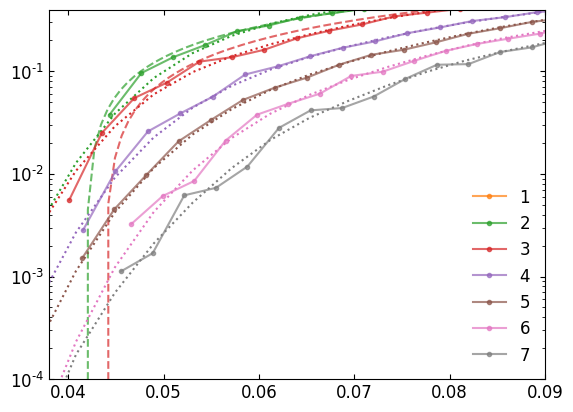

In [28]:
figure()

Pτ_modes_op = {}
Pτ_modes_op_analytic = {}

for i,c in cmodes_op_noclik.items():
    
    # MC-based
    Pτ = Pτ_modes_op[i] = vectorize(getτprior(c,smooth=0.1))
    c.like1d("cosmo.tau_out",maxed=True, c="C%i"%i, alpha=0.7, label=i, kde=False, smooth=False, marker=".",nbins=100)
    if i>1: plot(τs, Pτ(τs), "C%i:"%i)
    with open("taupriors/mh_xepcs_op_nmodes%i.dat"%i,"wb") as f:
        pickle.dump(Pτ,f)
        
    # analytic
    _τs = linspace(-r*norm(dτ_dmᵢ[:i])+τfid,r*norm(dτ_dmᵢ[:i])+τfid,500)
    Pτ = Pτ_modes_op_analytic[i] = vectorize(partial((lambda dτ_dmᵢ,i,τ: (1-((τ-τfid)/norm(dτ_dmᵢ[:i])/r)**2)**((i-1)/2)),dτ_dmᵢ,i))
    if i<4:
        if i==2: Pτ = Pτ_modes2_op_analytic_m1cube
        if i==3: Pτ = Pτ_modes3_op_analytic_m1cube
        plot(_τs, Pτ(_τs),"C%i--"%i, alpha=0.7)
    #     with open("taupriors/mh_xepcs_op_analytic_nmodes%i.dat"%i,"wb") as f:
    #         pickle.dump(Pτ,f,recurse=True)
        
        
        
legend()
        
xlim(0.038,0.09)
ylim(1e-4,0.4)

yscale("log")

In [29]:
dτ_dmi[0] * sk.params.camb.mplus[0]

0.13344937416713606

In [30]:
Δτs = abs(dτ_dmi * sk.params.camb.mplus[:20])

In [31]:
for N in [2,3,4,5]:
    plot(τs,(lambda x: x/x.max())(real(fft.ifft(exp(1j*-2*pi*((1+τfid) if N%2==0 else τfid)*fft.helper.fftfreq(1024,2/1024))*prod([fft.fft(abs(τs) < Δτs[i]) for i in range(N)],axis=0)))),c="C%i"%N)


ValueError: operands could not be broadcast together with shapes (1024,) (50,) 

(0, 0.4)

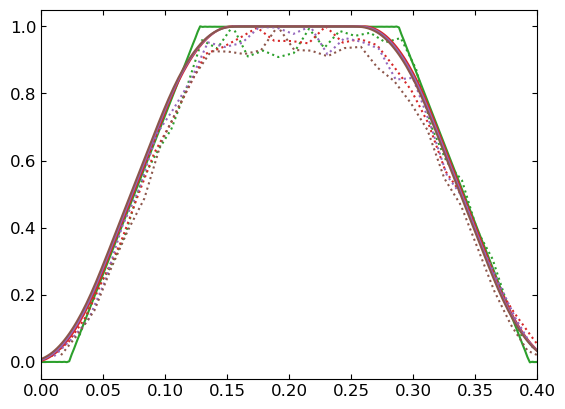

In [494]:
for N in [2,3,4,5]:
    plot(τs,(lambda x: x/x.max())(real(fft.ifft(exp(1j*-2*pi*((1+τfid) if N%2==0 else τfid)*fft.helper.fftfreq(1024,2/1024))*prod([fft.fft(abs(τs) < Δτs[i]) for i in range(N)],axis=0)))),c="C%i"%N)
    
#     cmodes_op_noclik[N].like1d("cosmo.tau_out",maxed=True,c="C%i"%N,ls="--")
    
    cmodes_op_noclik_cube[N].like1d("cosmo.tau_out",maxed=True,c="C%i"%N,ls=":",kde=False)
    
# plot(τs+τfid,abs(τs) < Δτs[0])
    
# plot([τfid]*2, ylim())
xlim(0,0.4)
# plot(τs,imag(fft.ifft(exp(1j*τfid*fft.helper.fftfreq(1024,1/1024))*prod([fft.fft(abs(τs) < Δτs[i]) for i in range(N)],axis=0))))*2,

In [246]:
cmodes_op_noclik_cube = {i: load_chain("chains/chain_reiomodes_fixclamp_nmodes%i_noclik_mh_xepcs_raw_mhpriorcube_mhfid_mhfidbase054_hardxe100200"%i).join()
                    for i in range(1,6)}

### Make figure

Removed no burn in


ValueError: operands could not be broadcast together with shapes (1024,) (50,) 

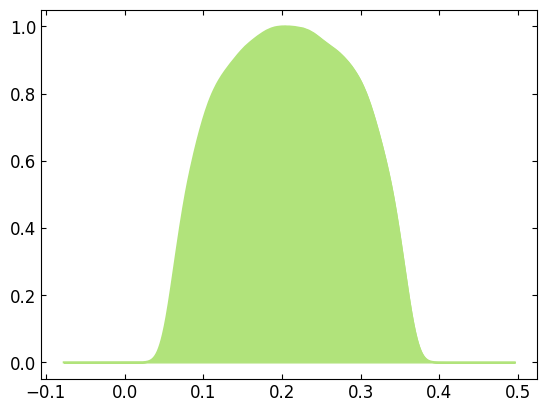

In [32]:
α=0.7
for i in range(2,8):
    c = get_cmap("viridis_r",7)(i-1)
    cmodes_op_noclik[i].thin(1).like1d("cosmo.tau_out",color=α*array(to_rgb(c))+(1-α),label="%i PCA modes"%i, kde=True,maxed=True, filled=1)
    
#     if i<6: cmodes_op_noclik_cube[i].thin(1).like1d("cosmo.tau_out",c=c,label="%i PCA modes"%i, lw=2, ls="--",kde=True,maxed=True)
    
    N=i
    plot(τs,(lambda x: x/x.max())(real(fft.ifft(exp(1j*-2*pi*((1+τfid) if N%2==0 else τfid)*fft.helper.fftfreq(1024,2/1024))*prod([fft.fft(abs(τs) < Δτs[i]) for i in range(N)],axis=0)))),
         c=c,ls="--",lw=1)

    
    _τs = linspace(-r*norm(dτ_dmᵢ[:i])+τfid,r*norm(dτ_dmᵢ[:i])+τfid,500)
    plot(_τs,Pτ_modes_op_analytic[i](_τs),c=c,ls=":",lw=2)

xlim(0,0.6)

/home/mmillea/.local/lib/python3.5/site-packages/ipykernel-4.5.2-py3.5.egg/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in double_scalars


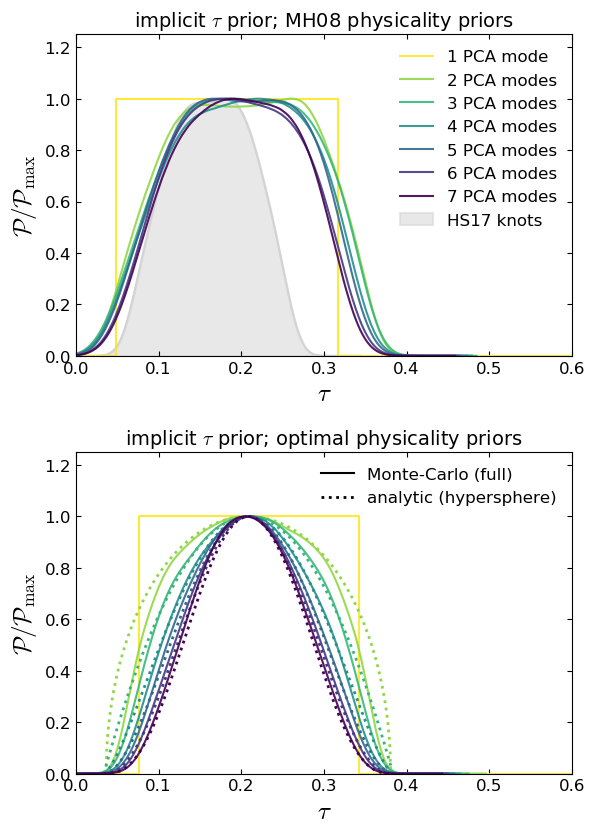

In [402]:
figure(figsize=(6.4,4.8*2))
subplots_adjust(hspace=0.3)

ax=subplot(211)
plot(hstack([0,[cmodes_noclik[1]['cosmo.tau_out'].min()]*2,[cmodes_noclik[1]['cosmo.tau_out'].max()]*2,0.6]),[0,0,1,1,0,0],
     c=get_cmap("viridis_r",7)(0),label='1 PCA mode',alpha=0.9)
for i in range(2,8):
    cmodes_noclik[i].thin(10).like1d("cosmo.tau_out",c=get_cmap("viridis_r",7)(i-1),label="%i PCA modes"%i,alpha=0.9,maxed=True)
    
    
cknots_noclik.like1d("cosmo.tau_out",color="lightgray",label="HS17 knots",filled=0.5,zorder=-1,maxed=True,lw=1.5)
legend()
xlabel(r"$\tau$",size=18)
ylabel(r"$\mathcal{P} / \mathcal{P}_{\rm max}$",size=18)
title(r"implicit $\tau$ prior; MH08 physicality priors",size=14)

subplot(212,sharex=ax,sharey=ax)
plot(hstack([0,[cmodes_op_noclik[1]['cosmo.tau_out'].min()]*2,[cmodes_op_noclik[1]['cosmo.tau_out'].max()]*2,0.6]),[0,0,1,1,0,0],
     c=get_cmap("viridis_r",7)(0),label='1 PCA mode',alpha=0.9)

for i in range(2,8):
    c = get_cmap("viridis_r",7)(i-1)
    cmodes_op_noclik[i].thin(1).like1d("cosmo.tau_out",c=c,label="%i PCA modes"%i, alpha=0.9,kde=True,maxed=True)
    
#     if i<6: cmodes_op_noclik_cube[i].thin(1).like1d("cosmo.tau_out",c=c,label="%i PCA modes"%i, lw=2, ls="--",kde=True,maxed=True)
    
    _τs = linspace(-r*norm(dτ_dmᵢ[:i])+τfid,r*norm(dτ_dmᵢ[:i])+τfid,500)
    plot(_τs,Pτ_modes_op_analytic[i](_τs),c=c,ls=":",lw=2)

ylim(0,1.25)
xlim(0,0.6)
legend(handles=[Line2D([], [], color='k', ls="-", label='Monte-Carlo (full)'),Line2D([], [], color='k', ls=":", lw=2, label='analytic (hypersphere)')])
xlabel(r"$\tau$",size=18)
ylabel(r"$\mathcal{P} / \mathcal{P}_{\rm max}$",size=18)
title(r"implicit $\tau$ prior; optimal physicality priors",size=14)

savefig("plots/implicit_tau_priors.pdf",bbox_inches="tight")

## Fig 2

In [135]:
cmodes_cp_simall = {i:load_chain("chains/chain_reiomodes_fixclamp_nmodes%i_onlylowp_simall_EE_mhprior_mhfid_mhfidbase054_mh_xepcs_raw_hardxe100200"%i).burnin(2000).join()
                 for i in range(2,6)}

In [136]:
cmodes_simall = {i:load_chain("chains/chain_reiomodes_fixclamp_nmodes%i_onlylowp_simall_EE_mhprior_mhfid_mh_xepcs_raw_hardxe100200"%i).burnin(2000).join()
                    for i in range(2,6)}

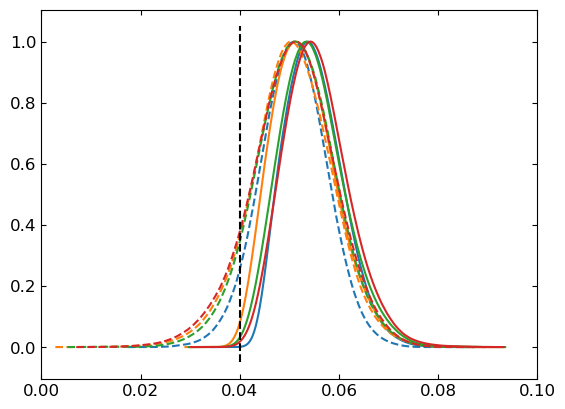

In [137]:
for i in range(2,6):
#     load_cosmomc_chain("polychord/reioflexknots_fixclamp_nmodes%i_onlylowp_simall_EE_gpprior_reiotau_xepcs_v3.txt"%i).like1d("cosmo.tau_out",ranges=(0.04,None),c="C%i"%(i-2))
    cmodes_simall[i].like1d("cosmo.tau_out",c="C%i"%(i-2),ls="--")
    cmodes_cp_simall[i].like1d("cosmo.tau_out",c="C%i"%(i-2),ls="-")
xlim(0,0.1)
plot([0.04]*2,ylim(),"k--")

In [7]:
# for i,c in cmodes_noclik.items():
#     with open('taupriors/mh_xepcs_nmodes%i.dat'%i,'wb')as f:
#         pickle.dump(getτprior(c),f)

In [8]:
cmodes5_bflike       = load_chain("chains/chain_reiomodes_fixclamp_nmodes5_onlylowp_bflike_mhprior_mhfid_mh_xepcs_raw_hardxe100200").burnin(3000).join()
cmodes5_bflike_flatτ = flatτ(cmodes5_bflike,cmodes_noclik[5])

In [9]:
cmodes5_simlow       = load_chain("chains/chain_reiomodes_fixclamp_nmodes5_onlylowp_simlow_mhprior_mhfid_mh_xepcs_raw_hardxe100200").burnin(3000).join().thin(3)
cmodes5_simlow_flatτ = flatτ(cmodes5_simlow,cmodes_noclik[5])

In [10]:
cknots_bflike       = load_chain("chains/chain_reioknots_fixclamp_knots_6_7.5_10_20_onlylowp_bflike_gpprior_reiotau_xepcs_v3").burnin(2000).join()
cknots_bflike_flatτ = flatτ(cknots_bflike,cknots_noclik)

In [11]:
cknots_simlow       = load_chain("chains/chain_reioknots_fixclamp_knots_6_7.5_10_20_onlylowp_simlow_gpprior_reiotau_xepcs_v3").burnin(3000).join()
cknots_simlow_flatτ = flatτ(cknots_simlow,cknots_noclik)

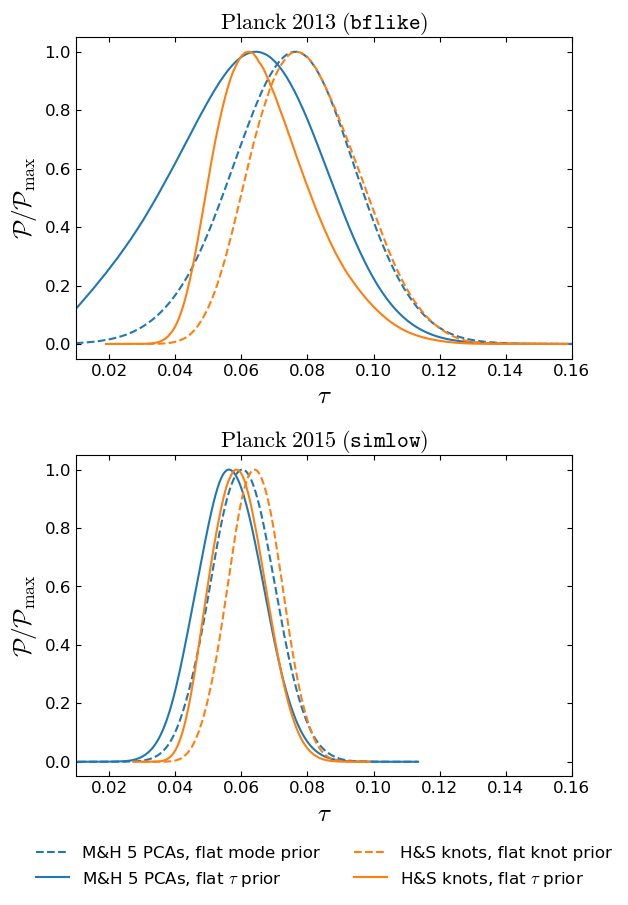

In [12]:
figure(figsize=(6.4,4.8*2))
subplots_adjust(hspace=0.3)


subplot(211)

cmodes5_bflike.like1d("cosmo.tau_out",c="C0",ls="--",label='M&H 5 PCAs, flat mode prior')
cmodes5_bflike_flatτ.like1d("cosmo.tau_out",c="C0", label=r'M&H 5 PCAs, flat $\tau$ prior')

cknots_bflike.like1d("cosmo.tau_out",c="C1",ls="--",label='H&S knots, flat knot prior')
cknots_bflike_flatτ.like1d("cosmo.tau_out",c="C1", label=r'H&S knots, flat $\tau$ prior')

xlabel(r"$\tau$",size=18)
ylabel(r"$\mathcal{P} / \mathcal{P}_{\rm max}$",size=18)
title(r"${\rm Planck \;2013} \;(\mathtt{bflike})$")



xlim(0.01,0.16)


subplot(212)

cmodes5_simlow.like1d("cosmo.tau_out",c="C0",ls="--",label='M&H 5 PCAs, flat mode prior')
cmodes5_simlow_flatτ.like1d("cosmo.tau_out",c="C0", label=r'M&H 5 PCAs, flat $\tau$ prior')

cknots_simlow.like1d("cosmo.tau_out",c="C1",ls="--",label='H&S knots, flat knot prior')
cknots_simlow_flatτ.like1d("cosmo.tau_out",c="C1", label=r'H&S knots, flat $\tau$ prior')

xlabel(r"$\tau$",size=18)
ylabel(r"$\mathcal{P} / \mathcal{P}_{\rm max}$",size=18)
title(r"${\rm Planck \;2015} \;(\mathtt{simlow})$")

legend(loc='upper center', bbox_to_anchor=(0.5, -0.17), ncol=2)


xlim(0.01,0.16)

savefig("plots/implicit_priors_impact.pdf",bbox_inches="tight")

## simlow data

In [52]:
cmodes5_simlow_op = load_chain("chains/chain_reiomodes_fixclamp_nmodes5_onlylowp_simlow_mhprior_mhfid_mhfidbase054_mh_xepcs_raw_hardxe100200").burnin(5000).join()
cmodes5_simlow_op['cosmo.tau15'] = τ15opfid + dot(array([cmodes5_simlow_op['cosmo.reiomodes.mode%i'%i] for i in range(5)]).T, dτ15op_dmi[:5])

cmodes5_simlow = load_chain("chains/chain_reiomodes_fixclamp_nmodes5_onlylowp_simlow_mhprior_mhfid_mh_xepcs_raw_hardxe100200").burnin(5000).join()

cmodes5_simlow_flatτ = flatτ(cmodes5_simlow, Pτ_modes[5])
cmodes5_simlow_op_flatτ = flatτ(cmodes5_simlow_op, Pτ_modes_op[5])

cmodes5_simlow_op_flatτ_analytic = flatτ(cmodes5_simlow_op, Pτ_modes_op_analytic[5])

cmodes5_simlow_op_flatτ_direct = load_chain("chains/chain_reiomodes_fixclamp_nmodes5_onlylowp_simlow_mh_xepcs_raw_mhpriorcubesphere_mhfid_mhfidbase054_undo_mh_xepcs_op_nmodes5_hardxe100200").burnin(2000).join()

cmodes5_simlow_op_flatτ_direct_analytic = load_chain("chains/chain_reiomodes_fixclamp_nmodes5_onlylowp_simlow_mh_xepcs_raw_mhpriorcubesphere_mhfid_mhfidbase054_undo_mh_xepcs_op_analytic_nmodes5_hardxe100200").burnin(2000).join()

cmodes5_simlow_op_flatτ15 = flatτ(cmodes5_simlow_op,getτprior(cmodes_op_noclik[5],k='cosmo.tau15'),k='cosmo.tau15')

Removed no burn in


(0.1, 2)

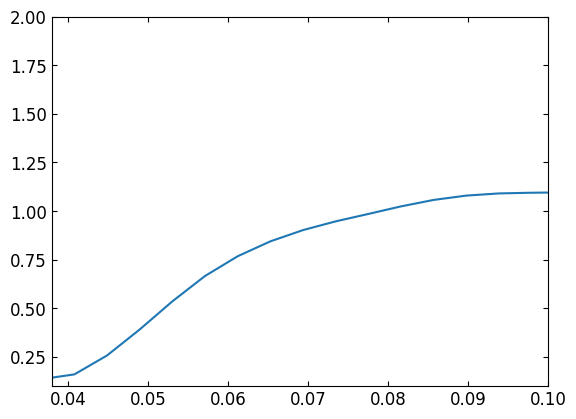

In [53]:
plot(τs,Pτ_modes_op[5](τs) / Pτ_modes_op_analytic[5](τs))
xlim(0.038,0.1)
ylim(1e-1,2)
# xscale("log")
# yscale("log")

/home/mmillea/.local/lib/python3.5/site-packages/ipykernel-4.5.2-py3.5.egg/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':


(0, 0.4)

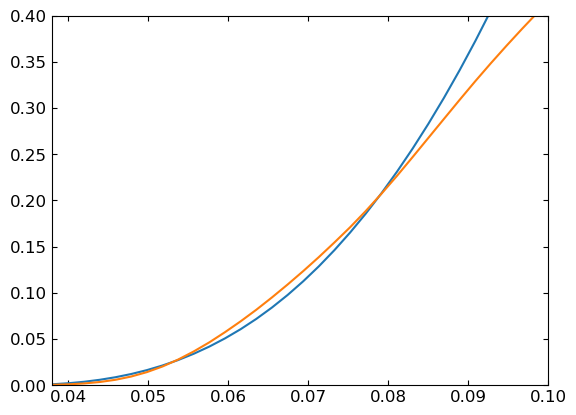

In [450]:
plot(τs,Pτ_modes_op_analytic[5](τs) * (τs/0.079)**1.5)
plot(τs,Pτ_modes_op[5](τs))

# cmodes_op_noclik[5].like1d("cosmo.tau_out",maxed=True,kde=False)

xlim(0.038,0.1)
ylim(0,0.4)

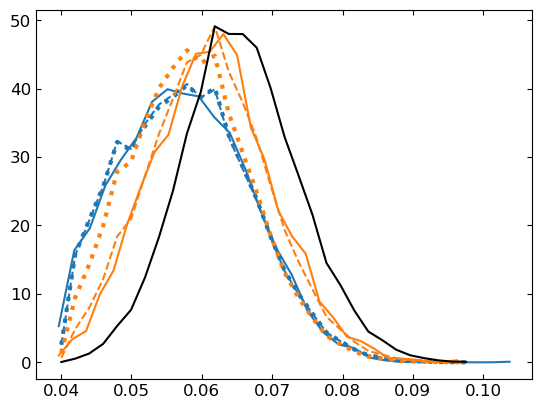

In [451]:
cmodes5_simlow_op_flatτ.like1d("cosmo.tau_out",kde=False,c="C0",ls="--")

flatτ(cmodes5_simlow_op, lambda τ: Pτ_modes_op[5](τ)).like1d("cosmo.tau_out",kde=False,c="C0",ls=":",lw=3)


cmodes5_simlow_op_flatτ_direct.like1d("cosmo.tau_out",kde=False,c="C0")

cmodes5_simlow_op_flatτ_analytic.like1d("cosmo.tau_out",kde=False,c="C1",ls="--")

flatτ(cmodes5_simlow_op, lambda τ: Pτ_modes_op_analytic[5](τ) * (τ/0.079)**2).like1d("cosmo.tau_out",kde=False,c="C1",ls=":",lw=3)

cmodes5_simlow_op_flatτ_direct_analytic.like1d("cosmo.tau_out",kde=False,c="C1")

cmodes5_simlow_op.like1d("cosmo.tau_out",kde=False,c="k")

In [21]:
# cmodes5_simlow_flatτ = load_chain("chains/chain_reiomodes_fixclamp_nmodes5_onlylowp_simlow_mhprior_mhfid_mh_xepcs_raw_undo_mh_xepcs_nmodes5_hardxe100200").burnin(5000).join()
# cmodes5_simlow_op_flatτ = load_chain("chains/chain_reiomodes_fixclamp_nmodes5_onlylowp_simlow_mhprior_mhfid_mhfidbase054_mh_xepcs_raw_undo_mh_xepcs_op_nmodes5_hardxe100200").burnin(5000).join()


In [22]:
cmodes5_simlow_op_flatτ_analytic = flatτ(cmodes5_simlow_op, Pτ_modes_op_analytic[5])

In [113]:
# cflex_simlow = {i:load_polychord("polychord/reioflexknots2_fixclamp_nmodes%i_onlylowp_simlow_gpprior"%i,Z0=47) for i in range(1,6)}

# for i in [1,2,3,4,5]:
#     sk = Slik(load_script('planck_reio3.py')[1](
#         modesfile="mh_xepcs_raw.dat",model="reioflexknots2_fixclamp",nmodes=i,no_clik=True,only_lowp=True,gpprior=True))

#     Z = cflex_simlow[i].Z
#     cflex_simlow[i] = cflex_simlow[i].postprocd(lambda **s: {"cosmo.tau15":sk.evaluate(*[s[k] for k in sk.get_sampled()])[1].cosmo.tau15_out})
#     cflex_simlow[i].Z = Z
    
#     with open("polychord/reioflexknots2_fixclamp_nmodes%i_onlylowp_simlow_gpprior_pptau15"%i,"wb") as f:
#         pickle.dump(cflex_simlow[i], f)
    
#     print(i)

1
2
3
4
5


In [54]:
cflex_simlow = {i: pickle.load(open("polychord/reioflexknots2_fixclamp_nmodes%i_onlylowp_simlow_gpprior_pptau15"%i,"rb")) for i in range(1,6)}

In [55]:
cflex_simlow_flatτ = {i: flatτ(cflex_simlow[i], getτprior(cflex_noclik[i],ranges=(τmin_gp,None)), maxweight=100) for i in cflex_simlow}

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


In [56]:
cflex_simlow_flatτ15 = {i: flatτ(cflex_simlow[i], getτprior(cflex_noclik[i],k="cosmo.tau15_out",ranges=(0,None)), maxweight=10000, k="cosmo.tau15") for i in cflex_simlow}

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


Removed no burn in
Removed no burn in
Removed no burn in


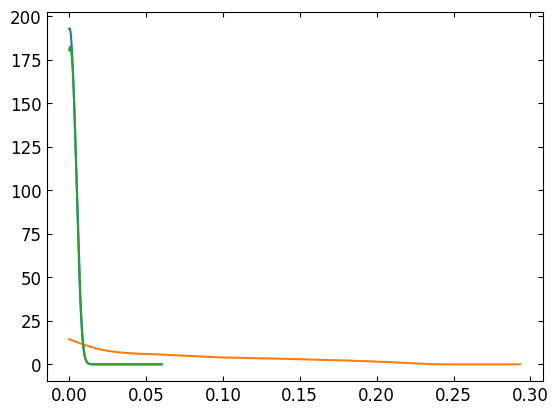

In [57]:
cflex_simlow[1].join().like1d("cosmo.tau15", ranges=(0,None))
cflex_noclik[1].join().like1d("cosmo.tau15_out", ranges=(0,None))
cflex_simlow_flatτ15[1].join().like1d("cosmo.tau15", ranges=(0,None))

In [27]:
Chains([cflex_simlow[i] for i in range(1,4)]).join().confbound("cosmo.tau15")

(3.0684961655692232e-07, 0.014589902453105902)

In [28]:
Chains([cflex_simlow_flatτ15[i] for i in range(1,4)]).join().confbound("cosmo.tau15", level=0.95)

(3.0684961655692232e-07, 0.01391956100022152)

In [29]:
cmodes5_simlow_op_flatτ15.mean('cosmo.tau15') / cmodes5_simlow_op_flatτ15.std('cosmo.tau15')

0.79158823340309803

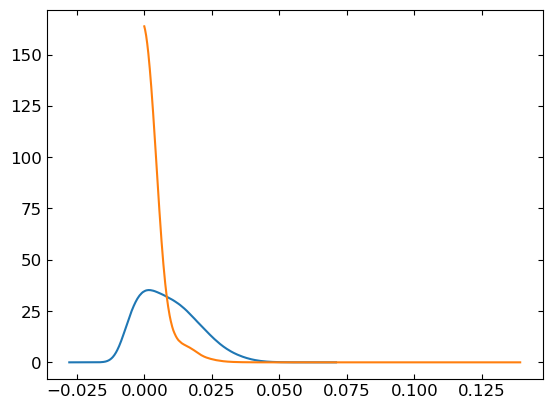

In [30]:
cmodes5_simlow_op_flatτ15.like1d("cosmo.tau15")
Chains(cflex_simlow_flatτ15.values()).join().like1d("cosmo.tau15",ranges=(0,None))

In [59]:
cmodes5_simlow_op_flatτ15.confbound("cosmo.tau15",level=0.95)

(-0.013475544646591689, 0.02881524796190462)

In [32]:
ctau_simlow = load_chain("chains/chain_reiotanh_fixclamp_onlylowp_simlow_reiotau_xepcs_v3").join().thin(100)
# ctau_simlow = ctau_simlow.sample(ctau_simlow['cosmo.tau_out']>0.048)

In [33]:
Chains(cflex_simlow_flatτ.values()).join()

                 # of steps:  18592
               total weight:  2.55
                 acceptance:  7.28e+03
                   cosmo.H0:       66.81 ± 1.421e-14
    cosmo.reioflexknots.xe0:      0.2184 ± 0.2213
     cosmo.reioflexknots.z0:       9.023 ± 4.063
                cosmo.tau15:    0.003807 ± 0.004348
              cosmo.tau_out:     0.05742 ± 0.009211

In [34]:
ctau_simlow.sample(ctau_simlow['cosmo.tau_out']>τmin_tanh_gp)

            # of steps:  577
          total weight:  577.00
            acceptance:  1
              cosmo.H0:       66.81 ± 1.421e-14
             cosmo.tau:     0.05473 ± 0.00789
         cosmo.tau_out:     0.05602 ± 0.007891
            lnls.highl:           0 ± 0
    lnls.inv_tau_prior:           0 ± 0
            lnls.lowlP:      -49.49 ± 0.4975
            lnls.lowlT:           0 ± 0

In [35]:
Chains(cflex_simlow_flatτ.values()).join()

                 # of steps:  18592
               total weight:  2.55
                 acceptance:  7.28e+03
                   cosmo.H0:       66.81 ± 1.421e-14
    cosmo.reioflexknots.xe0:      0.2184 ± 0.2213
     cosmo.reioflexknots.z0:       9.023 ± 4.063
                cosmo.tau15:    0.003807 ± 0.004348
              cosmo.tau_out:     0.05742 ± 0.009211

In [36]:
Chains(cflex_simlow_flatτ.values()).join().std("cosmo.tau_out") / ctau_simlow.sample(ctau_simlow['cosmo.tau_out']>τmin_tanh_gp).std("cosmo.tau_out")

1.1672817439247594

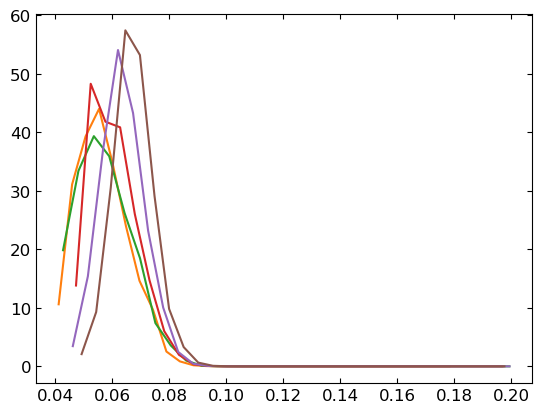

In [37]:
for i in range(1,6):
    
#     cflex_simlow[i].like1d("cosmo.tau_out", kde=False, label=r"%i FlexKnots (flat $\tau$)"%i,c="C%i"%i,ls="-.")
    cflex_simlow_flatτ[i].like1d("cosmo.tau_out", kde=False, label=r"%i FlexKnots (flat $\tau$)"%i,c="C%i"%i)
    
#     cflex_noclik[i].like1d("cosmo.tau_out", kde=False, label=r"%i FlexKnots (flat $\tau$)"%i,c="C%i"%i,ls=":")
    
#     flatτ(cflex_simlow[i],getτprior(cflex_noclik[i],ranges=(τmin_gp,None)),maxweight=100).like1d("cosmo.tau_out", kde=False, label=r"%i FlexKnots (flat $\tau$)"%i,c="C%i"%i,ls="--")

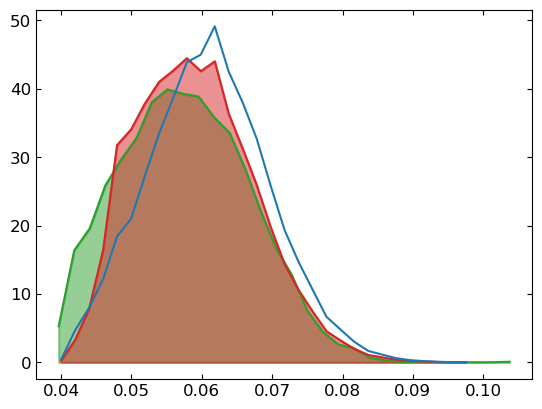

In [60]:
cmodes5_simlow_op_flatτ_direct.like1d("cosmo.tau_out",color="C2",filled=True,lw=1.5,kde=False,label=r"PCA, flat $\tau$, optimal phys.",maxed=maxed)
cmodes5_simlow_op_flatτ.like1d("cosmo.tau_out",color="C3",filled=True,lw=1.5,kde=False,label=r"PCA, flat $\tau$, optimal phys.",maxed=maxed)

# cmodes5_simlow_op_flatτ_direct_analytic.like1d("cosmo.tau_out",color="C4",filled=True,lw=1.5,kde=False,label=r"PCA, flat $\tau$, optimal phys.",maxed=maxed)
cmodes5_simlow_op_flatτ_analytic.like1d("cosmo.tau_out",kde=False)

In [65]:
Chains(cflex_simall.values())

                # of chains:  5
                 # of steps:  21463
               total weight:  0.29
                 acceptance:  7.45e+04
                   cosmo.H0:       66.81 ± 1.421e-14
    cosmo.reioflexknots.xe0:      0.1747 ± 0.1957
     cosmo.reioflexknots.z0:       8.249 ± 2.726
              cosmo.tau_out:     0.05411 ± 0.0066

In [64]:
Chains(cflex_simlow.values())

                # of chains:  5
                 # of steps:  18592
               total weight:  2.55
                 acceptance:  7.28e+03
                   cosmo.H0:       66.81 ± 0
    cosmo.reioflexknots.xe0:      0.2345 ± 0.2208
     cosmo.reioflexknots.z0:       9.475 ± 4.365
                cosmo.tau15:    0.005104 ± 0.005333
              cosmo.tau_out:     0.06174 ± 0.009302

/home/mmillea/.local/lib/python3.5/site-packages/scipy-0.18.0-py3.5-linux-x86_64.egg/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


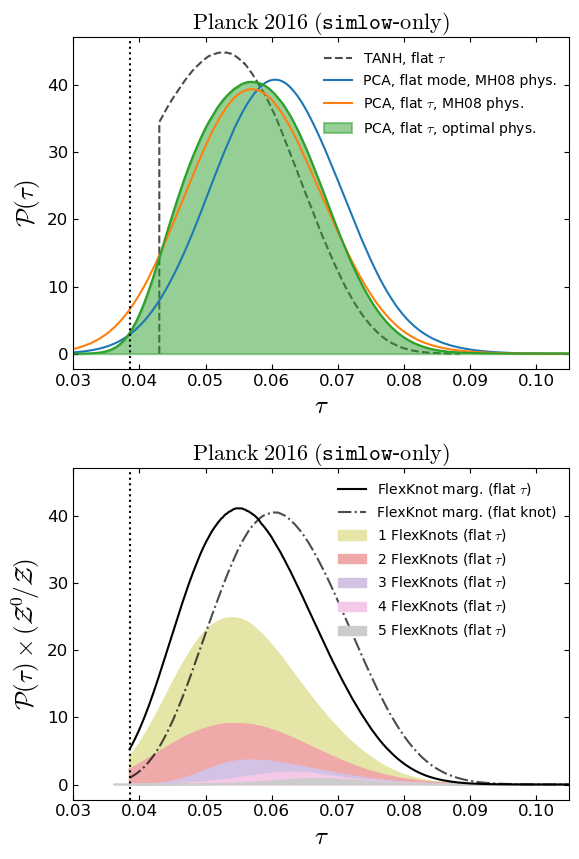

In [38]:
figure(figsize=(6.4,2*4.8+0.3))
subplots_adjust(hspace=0.3)

subplot(211)

maxed=False
ctau_simlow.like1d('cosmo.tau_out',maxed=maxed,ranges=(τmin_tanh_gp,None),zero_endpoints=True,color="k",alpha=0.7,zorder=-1,filled=False,ls="--", label=r"TANH, flat $\tau$")
cmodes5_simlow.like1d("cosmo.tau_out", label="PCA, flat mode, MH08 phys.",maxed=maxed)
cmodes5_simlow_flatτ.like1d("cosmo.tau_out", label=r"PCA, flat $\tau$, MH08 phys.",maxed=maxed)
cmodes5_simlow_op_flatτ_direct.like1d("cosmo.tau_out",color="C2",filled=True,lw=1.5,kde=True,label=r"PCA, flat $\tau$, optimal phys.",maxed=maxed)

# cmodes5_simlow_op.like1d("cosmo.tau_out",maxed=maxed,ls="--")


_ylim=ylim()
plot([τmin_gp]*2, ylim(),"k:")
ylim(_ylim)

xlim(0.03,0.105)
# ylim(-0.05,1.05)
legend(prop={'size': 10})

title(r"${\rm Planck \;2016} \;(\mathtt{simlow}$-$\rm only)$")
xlabel(r"$\tau$",size=18)
ylabel(r"$\mathcal{P}(\tau)$",size=18)


# =====================
subplot(212)

α = 0.4
Z0 = max(c.Z for c in cflex_simlow_flatτ.values())
W = sum(exp(c.Z-Z0) for c in cflex_simlow_flatτ.values()) / 40
for i,c in cflex_simlow_flatτ.items():
    c.like1d("cosmo.tau_out",maxed=exp(c.Z-Z0)/W,filled=1,zorder=-c.Z,
             color=tuple(α*array(cm.tab10.colors)[[3,4,6,7,8]][i-2]+(1-α)), label=r"%i FlexKnots (flat $\tau$)"%i,ranges=(τmin_gp,None))

Chains(cflex_simlow_flatτ.values()).join().like1d('cosmo.tau_out', maxed=False, color="k", label=r'FlexKnot marg. (flat $\tau$)',ranges=(τmin_gp,None))
Chains(cflex_simlow.values()).join().like1d('cosmo.tau_out', maxed=False, color="k", alpha=0.7, ls="-.", label=r'FlexKnot marg. (flat knot)',ranges=(τmin_gp,None))

xlim(0.03,0.105)
legend(prop={'size': 10})

plot([τmin_gp]*2, _ylim,"k:")
ylim(_ylim)


title(r"${\rm Planck \;2016} \;(\mathtt{simlow}$-$\rm only)$")
xlabel(r"$\tau$",size=18)
ylabel(r"$\mathcal{P}(\tau)\times(\mathcal{Z}^0\!/\mathcal{Z})$",size=18)


savefig('plots/data_simlow.pdf',bbox_inches='tight')


In [28]:
cmodes5_simlow_op_flatτ

               # of steps:  40456
             total weight:  1547197.63
               acceptance:  0.0261
                 cosmo.H0:       66.81 ± 0
    cosmo.reiomodes.mode0:     -0.3976 ± 0.03171
    cosmo.reiomodes.mode1:       0.206 ± 0.07277
    cosmo.reiomodes.mode2:     -0.1147 ± 0.1249
    cosmo.reiomodes.mode3:     0.02685 ± 0.1129
    cosmo.reiomodes.mode4:    -0.02217 ± 0.1169
            cosmo.tau_out:     0.06028 ± 0.008236
               lnls.highl:           0 ± 0
       lnls.inv_tau_prior:           0 ± 0
               lnls.lowlP:      -49.71 ± 0.7232
               lnls.lowlT:           0 ± 0

In [29]:
cmodes5_simlow_op

               # of steps:  40456
             total weight:  95729.00
               acceptance:  0.423
                 cosmo.H0:       66.81 ± 0
    cosmo.reiomodes.mode0:     -0.3862 ± 0.03367
    cosmo.reiomodes.mode1:      0.2014 ± 0.07753
    cosmo.reiomodes.mode2:    -0.09634 ± 0.1369
    cosmo.reiomodes.mode3:     0.02252 ± 0.123
    cosmo.reiomodes.mode4:    -0.01487 ± 0.1286
            cosmo.tau_out:     0.06546 ± 0.008238
               lnls.highl:           0 ± 0
       lnls.inv_tau_prior:           0 ± 0
               lnls.lowlP:      -49.46 ± 0.9765
               lnls.lowlT:           0 ± 0

In [30]:
Chains(cflex_simlow_flatτ.values()).join()

                 # of steps:  18589
               total weight:  2.55
                 acceptance:  7.28e+03
                   cosmo.H0:       66.81 ± 1.421e-14
    cosmo.reioflexknots.xe0:      0.2225 ± 0.2217
     cosmo.reioflexknots.z0:       9.082 ± 4.069
              cosmo.tau_out:     0.05806 ± 0.008814

In [31]:
Chains(cflex_simlow.values()).join()

                 # of steps:  18592
               total weight:  2.55
                 acceptance:  7.28e+03
                   cosmo.H0:       66.81 ± 0
    cosmo.reioflexknots.xe0:      0.2345 ± 0.2208
     cosmo.reioflexknots.z0:       9.475 ± 4.365
              cosmo.tau_out:     0.06174 ± 0.009302

In [32]:
(Chains(cflex_simlow.values()).join().mean('cosmo.tau_out') - Chains(cflex_simlow_flatτ.values()).join().mean('cosmo.tau_out')) / 0.009

0.40900669256663175

In [74]:
cmodes5_simlow_op['cosmo.tau15'] = τ15opfid + dot(array([cmodes5_simlow_op['cosmo.reiomodes.mode%i'%i] for i in range(5)]).T, dτ15op_dmi[:5])

### Clip

In [168]:
c=load_chain("chains/chain_reiomodes_fixclamp_nmodes5_onlylowp_simlow_mh_xepcs_raw_mhpriorcubesphere_mhfid_mhfidbase054_clip_hardxe100200").burnin(600).join()

In [169]:
cp=load_chain("chains/chain_reiomodes_fixclamp_nmodes5_noclik_mh_xepcs_raw_mhpriorcubesphere_mhfid_mhfidbase054_clip_hardxe100200").burnin(1000).join()

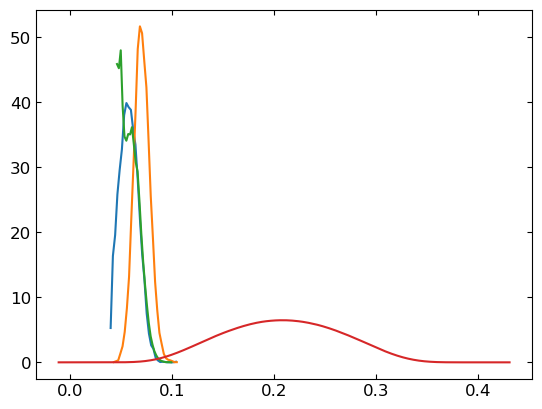

In [171]:
cmodes5_simlow_op_flatτ_direct.like1d("cosmo.tau_out",kde=False)
c.like1d("cosmo.tau_out",kde=False)
flatτ(c,getτprior(cp)).like1d("cosmo.tau_out",kde=False,ranges=(0.045,0.1))
cp.like1d("cosmo.tau_out")

## bflike data

In [61]:
clcdmtau_bflike = load_chain('chains/chain_lcdm_reiotanh_bflike_reiotau_xepcs_v3').burnin(2000).join().thin(5)
clcdmtau_bflike = clcdmtau_bflike.sample(clcdmtau_bflike['cosmo.tau']>τmin_tanh_gp)

In [62]:
clcdm_modes5_bflike = load_chain('chains/chain_lcdm_reiomodes_nmodes5_bflike_mhprior_mhfid_mh_xepcs_raw_hardxe100200').burnin(1000).join()
clcdm_modes5_op_bflike = load_chain('chains/chain_lcdm_reiomodes_nmodes5_bflike_mhprior_mhfid_mhfidbase054_mh_xepcs_raw_hardxe100200').burnin(1000).join()

In [63]:
cmodes5_bflike_op = load_chain("chains/chain_reiomodes_fixclamp_nmodes5_onlylowp_bflike_mhprior_mhfid_mhfidbase054_mh_xepcs_raw_hardxe100200").burnin(2000).join()
cmodes5_bflike = load_chain("chains/chain_reiomodes_fixclamp_nmodes5_onlylowp_bflike_mhprior_mhfid_mh_xepcs_raw_hardxe100200").burnin(2000).join()
cmodes5_bflike_flatτ = load_chain("chains/chain_reiomodes_fixclamp_nmodes5_onlylowp_bflike_mhprior_mhfid_mh_xepcs_raw_undo_mh_xepcs_nmodes5_hardxe100200").burnin(2000).join()
cmodes5_bflike_op_flatτ = load_chain("chains/chain_reiomodes_fixclamp_nmodes5_onlylowp_bflike_mhprior_mhfid_mhfidbase054_mh_xepcs_raw_undo_mh_xepcs_op_nmodes5_hardxe100200").burnin(2000).join()

In [64]:
ctau_bflike = load_chain("chains/chain_reiotanh_fixclamp_onlylowp_bflike_reiotau_xepcs_v3").join()
ctau_bflike = ctau_bflike.sample(ctau_bflike['cosmo.tau_out']>τmin_tanh_gp)

### No LCDM

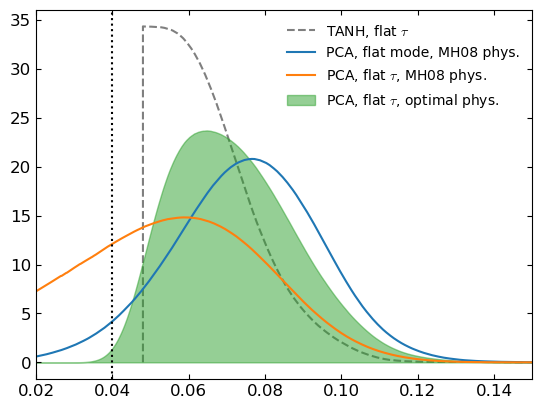

In [225]:
maxed=False
ctau_bflike.like1d('cosmo.tau_out',maxed=maxed,ranges=(0.048,None),zero_endpoints=True,color="k",alpha=0.5,zorder=-1,filled=False,ls="--", label=r"TANH, flat $\tau$")

cmodes5_bflike.like1d("cosmo.tau_out", label="PCA, flat mode, MH08 phys.",maxed=maxed)
cmodes5_bflike_flatτ.like1d("cosmo.tau_out", label=r"PCA, flat $\tau$, MH08 phys.",maxed=maxed)
cmodes5_bflike_op_flatτ.like1d("cosmo.tau_out",color="C2",filled=True,alpha=0.5,kde=True,label=r"PCA, flat $\tau$, optimal phys.",maxed=maxed)

# cmodes5_bflike_op.like1d("cosmo.tau_out",maxed=maxed)

_ylim=ylim()
plot([0.04]*2, ylim(),"k:")
ylim(_ylim)

xlim(0.02,0.15)
# ylim(-0.05,1.05)
legend(prop={'size': 10})


# Chains(cflex_simlow.values()).join().like1d('cosmo.tau_out',c="k",kde=True,ranges=(0.04,None))

### with LCDM

In [65]:
clcdm_modes5_bflike['cosmo.tau15'] = τ15fid + dot(array([clcdm_modes5_bflike['cosmo.reiomodes.mode%i'%i] for i in range(5)]).T, dτ15_dmi[:5])
clcdm_modes5_op_bflike['cosmo.tau15'] = τ15opfid + dot(array([clcdm_modes5_op_bflike['cosmo.reiomodes.mode%i'%i] for i in range(5)]).T, dτ15op_dmi[:5])
clcdm_modes5_op_bflike_flatτ = flatτ(clcdm_modes5_op_bflike.thin(10), Pτ_modes_op[5])
clcdm_modes5_op_bflike_flatτ15 = flatτ(clcdm_modes5_op_bflike.thin(10), getτprior(cmodes_op_noclik[5],k='cosmo.tau15'), k='cosmo.tau15')

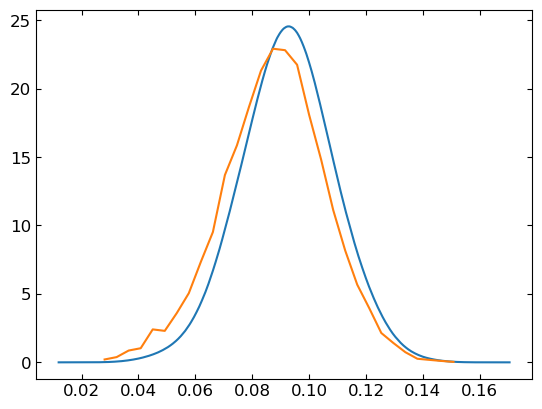

In [76]:
clcdm_modes5_bflike.like1d("cosmo.tau_out")
flatτ(clcdm_modes5_bflike,Pτ_modes[5],maxweight=100).like1d("cosmo.tau_out",color="C1", label=r'PCA, flat $\tau$, MH08 phys.',maxed=maxed,kde=False)
# flatτ(clcdm_modes5_bflike,Pτ_modes_op_analytic[5],maxweight=100).like1d("cosmo.tau_out",color="C1", label=r'PCA, flat $\tau$, MH08 phys.',maxed=maxed,kde=False)


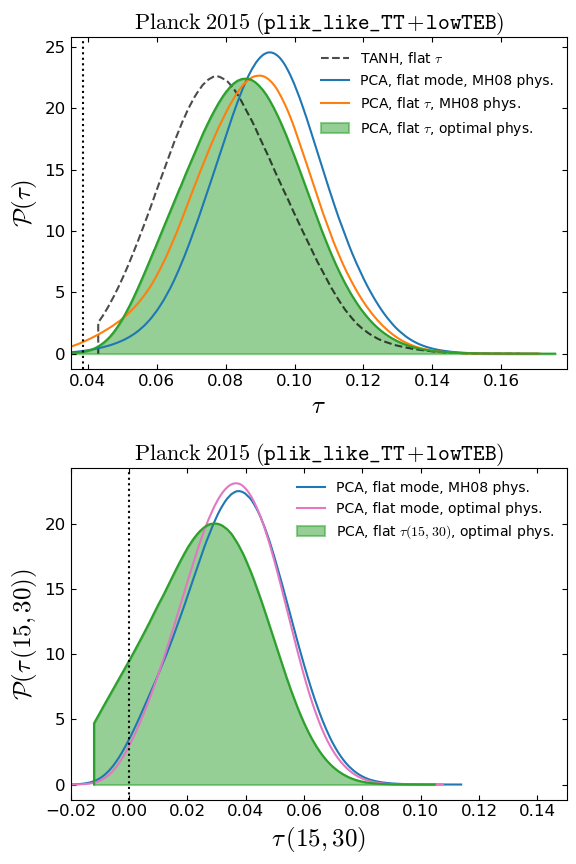

In [287]:
figure(figsize=(6.4,2*4.8+0.3))
subplots_adjust(hspace=0.3)

subplot(211)


maxed=False
clcdmtau_bflike.thin(5).like1d("cosmo.tau_out", c="k", ls="--", alpha=0.7, label=r'TANH, flat $\tau$',maxed=maxed, ranges=(τmin_tanh_gp,None), zero_endpoints=True)
clcdm_modes5_bflike.like1d("cosmo.tau_out",c="C0",label='PCA, flat mode, MH08 phys.',maxed=maxed)
flatτ(clcdm_modes5_bflike.thin(10),Pτ_modes[5]).like1d("cosmo.tau_out",color="C1", label=r'PCA, flat $\tau$, MH08 phys.',maxed=maxed)

clcdm_modes5_op_bflike_flatτ.like1d('cosmo.tau_out',
      maxed=maxed, color='C2', filled=True, lw=1.5, label=r'PCA, flat $\tau$, optimal phys.')

_ylim=ylim()
plot([τmin_gp]*2, ylim(),"k:")
ylim(_ylim)


legend(loc='upper right', prop={'size': 10})
xlabel(r"$\tau$",size=18)
ylabel(r"$\mathcal{P}(\tau)$",size=18)
xlim(0.035,0.179)
title(r"${\rm Planck \;2015} \;(\mathtt{plik\_like\_TT+lowTEB})$")


subplot(212)

clcdm_modes5_bflike.like1d("cosmo.tau15",c='C0',maxed=maxed,label='PCA, flat mode, MH08 phys.')
clcdm_modes5_op_bflike.like1d("cosmo.tau15",c='C6',maxed=maxed,label='PCA, flat mode, optimal phys.')

clcdm_modes5_op_bflike_flatτ15.like1d('cosmo.tau15',
   maxed=maxed, color='C2', filled=True, lw=1.5, label=r'PCA, flat $\tau(15,30)$, optimal phys.',kde=True, ranges=(-0.012,None), zero_endpoints=True)


_ylim=ylim()
plot([0]*2, ylim(),"k:")
ylim(_ylim)

xlim(-0.02,0.15)
title(r"${\rm Planck \;2015} \;(\mathtt{plik\_like\_TT+lowTEB})$")


legend(loc='upper right', prop={'size': 10})
xlabel(r"$\tau\,(15,30)$",size=18)
ylabel(r"$\mathcal{P}(\tau\,(15,30))$",size=18)

savefig('plots/data_plikTT_bflike.pdf',bbox_inches='tight')

In [277]:
clcdm_modes5_bflike.mean('cosmo.tau15') / clcdm_modes5_bflike.std('cosmo.tau15')

2.05465641519468

In [278]:
c = clcdm_modes5_op_bflike_flatτ15
c.mean('cosmo.tau15') / c.std('cosmo.tau15')

1.4562531568596768

In [293]:
clcdmtau_bflike

            # of steps:  7818
          total weight:  8185.00
            acceptance:  0.955
             calPlanck:           1 ± 0.002479
              cosmo.H0:       67.33 ± 0.9704
            cosmo.logA:       3.095 ± 0.03313
              cosmo.ns:      0.9647 ± 0.006109
           cosmo.ombh2:     0.02221 ± 0.0002248
           cosmo.omch2:      0.1197 ± 0.002167
             cosmo.tau:     0.07907 ± 0.01732
         cosmo.tau_out:     0.08036 ± 0.01733
           cosmo.theta:     0.01041 ± 4.751e-06
            lnls.highl:       104.4 ± 1.806
    lnls.inv_tau_prior:           0 ± 0
            lnls.lowlP:        5249 ± 1.239
            lnls.lowlT:           0 ± 0

In [296]:
clcdm_modes5_bflike

               # of steps:  33507
             total weight:  78601.00
               acceptance:  0.426
                calPlanck:           1 ± 0.002512
                 cosmo.H0:       67.58 ± 0.9632
               cosmo.logA:       3.116 ± 0.03235
                 cosmo.ns:      0.9686 ± 0.006348
              cosmo.ombh2:     0.02225 ± 0.0002283
              cosmo.omch2:      0.1191 ± 0.002153
    cosmo.reiomodes.mode0:    0.008586 ± 0.05561
    cosmo.reiomodes.mode1:    -0.01735 ± 0.1029
    cosmo.reiomodes.mode2:     0.01757 ± 0.1292
    cosmo.reiomodes.mode3:    0.007713 ± 0.139
    cosmo.reiomodes.mode4:     0.02672 ± 0.147
              cosmo.tau15:     0.03564 ± 0.01735
            cosmo.tau_out:     0.09248 ± 0.01672
              cosmo.theta:     0.01041 ± 4.724e-06
               lnls.highl:       104.4 ± 1.882
       lnls.inv_tau_prior:           0 ± 0
               lnls.lowlP:        5247 ± 1.264
               lnls.lowlT:           0 ± 0

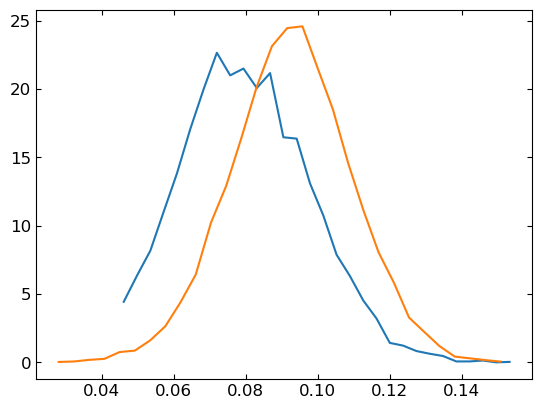

In [290]:
clcdmtau_bflike.like1d("cosmo.tau_out",kde=False)
clcdm_modes5_bflike.like1d("cosmo.tau_out",kde=False)

In [298]:
(clcdmtau_bflike.mean("cosmo.tau_out") - clcdm_modes5_bflike.mean("cosmo.tau_out")) / clcdm_modes5_bflike.std("cosmo.tau_out")

-0.72443850978280766

In [292]:
(clcdmtau_bflike.mean("cosmo.tau_out") - clcdm_modes5_op_bflike_flatτ.mean("cosmo.tau_out")) / clcdm_modes5_bflike.std("cosmo.tau_out")

-0.30781904335275861

#### Reproduce Fig 3 from Heinrich

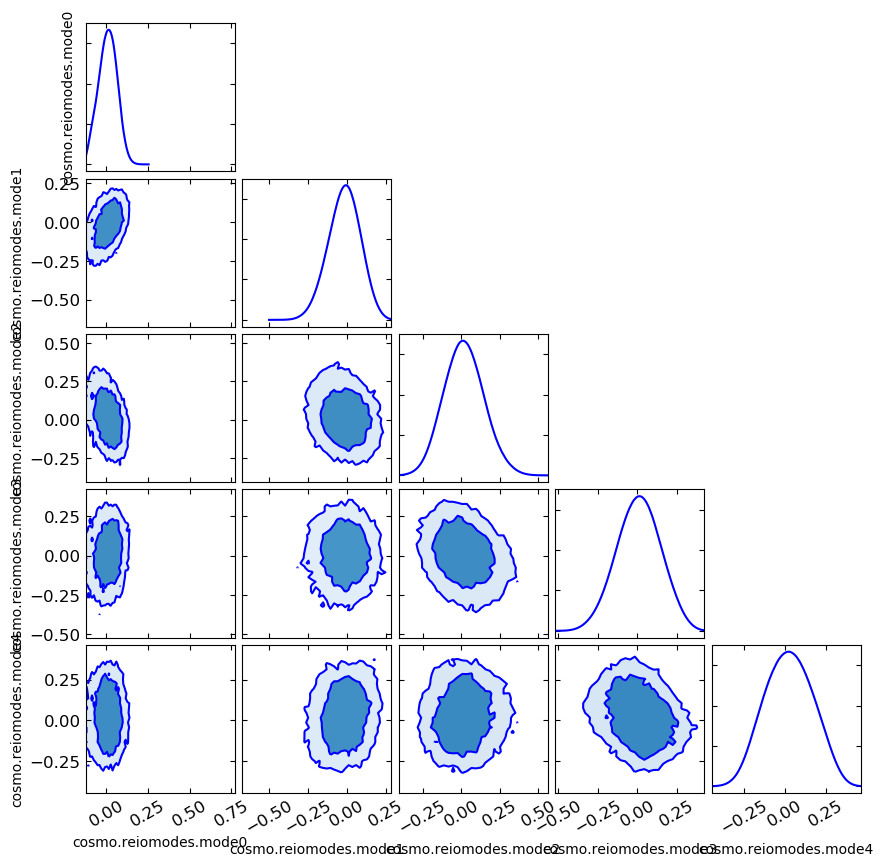

In [18]:
clcdm_modes5_bflike.likegrid(params=["cosmo.reiomodes.mode%i"%i for i in range(5)],
                            lims={'cosmo.reiomodes.mode0': (-0.12398686212478711, 0.7686053481529491),
 'cosmo.reiomodes.mode1': (-0.6721251419780893, 0.28198661756082527),
 'cosmo.reiomodes.mode2': (-0.40601320116896933, 0.5587884568846968),
 'cosmo.reiomodes.mode3': (-0.5201847498154827, 0.41969474771722787),
 'cosmo.reiomodes.mode4': (-0.4470300433778446, 0.4632551416582083)}
, nbins2d=30
)

## simall

In [39]:
cmodes5_op_simall = load_chain("chains/chain_reiomodes_fixclamp_nmodes5_onlylowp_simall_EE_mhprior_mhfid_mhfidbase054_mh_xepcs_raw_hardxe100200").burnin(5000).join()

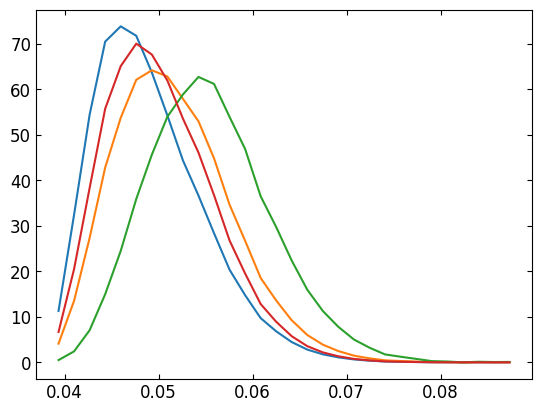

In [40]:
flatτ(cmodes5_op_simall, Pτ_modes_op[5]).like1d('cosmo.tau_out',kde=False)
flatτ(cmodes5_op_simall, Pτ_modes_op_analytic[5]).like1d('cosmo.tau_out',kde=False)

cmodes5_op_simall.like1d('cosmo.tau_out',kde=False)

flatτ(cmodes5_op_simall, lambda τ: Pτ_modes_op_analytic[5](τ) * (τ/0.079)**2).like1d('cosmo.tau_out',kde=False)

In [41]:
ctau_simall = load_chain("chains/chain_reiotanh_fixclamp_onlylowp_simall_EE").burnin(500).join().thin(30)

In [188]:
cflex_simall = {i:load_polychord("polychord/reioflexknots2_fixclamp_nmodes%i_onlylowp_simall_EE_gpprior"%i,Z0=-200) for i in range(1,6)}

In [337]:
Chains(cflex_simlow.values()).join().confbound("cosmo.tau15",0.95)

(3.068496165569223e-07, 0.0170877692578761)

In [336]:
Chains(cflex_simlow_flatτ15.values()).join().confbound("cosmo.tau15",0.95)

(3.068496165569223e-07, 0.015315432635314286)

In [339]:
0.017/0.015 * 0.006

0.006800000000000001

In [259]:
cflex_simall_flatτ = {i:flatτ(cflex_simall[i], Pτ_flex[i]) for i in range(1,6)}
# for i,c in cflex_simall_flatτ.items():
#     c['weight'] *= exp(-(-200-cflex_simall[i].Z)) / sum(c['weight'])

In [260]:
Chains(cflex_simall_flatτ.values()).join().mean('cosmo.tau_out') - Chains(cflex_simall.values()).join().mean('cosmo.tau_out')

-0.0036859644870603572

In [261]:
ctau_simall.sample(ctau_simall["cosmo.tau_out"]>0.043)

            # of steps:  552
          total weight:  552.00
            acceptance:  1
              cosmo.H0:       66.81 ± 0
             cosmo.tau:     0.05054 ± 0.005782
         cosmo.tau_out:     0.05183 ± 0.005782
            lnls.highl:           0 ± 0
    lnls.inv_tau_prior:           0 ± 0
          lnls.lensing:           0 ± 0
            lnls.lowlP:       198.2 ± 0.6215
            lnls.lowlT:           0 ± 0

Removed no burn in
Removed no burn in
Removed no burn in


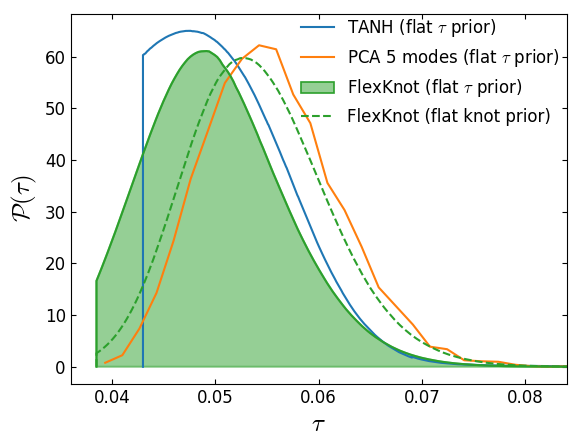

In [262]:
ctau_simall.like1d('cosmo.tau_out',ranges=(τmin_tanh_gp,None),zero_endpoints=True,c="C0",
                  label=r"TANH (flat $\tau$ prior)")

# flatτ(cmodes5_op_simall,Pτ_modes_op[5],maxweight=100).thin(10).like1d('cosmo.tau_out',c="C1",kde=False,
#                                                              label=r"PCA 5 modes (flat $\tau$ prior)")

cmodes5_op_simall.thin(10).like1d('cosmo.tau_out',c="C1",kde=False,
                                                             label=r"PCA 5 modes (flat $\tau$ prior)")


Chains(cflex_simall.values()).join().like1d("cosmo.tau_out",ranges=(τmin_gp,None),c="C2",zero_endpoints=True,ls="--",
                                           label=r"FlexKnot (flat knot prior)")

Chains(cflex_simall_flatτ.values()).join().like1d("cosmo.tau_out",ranges=(τmin_gp,None),color="C2",zero_endpoints=True,filled=0.5,
                                                  label=r"FlexKnot (flat $\tau$ prior)", lw=1.5)


handles, labels = gca().get_legend_handles_labels()
order = [0,1,3,2]
handles[3] = Patch(facecolor=(to_rgb("C2")+(0.5,)), edgecolor='C2', lw=1.2)
plt.legend([handles[i] for i in order],[labels[i] for i in order],loc=(0.45,0.68))


xlabel(r"$\tau$",size=18)
ylabel(r"$\mathcal{P}(\tau)$",size=18)

xlim(0.036,0.084)

savefig("plots/tau_simall_ee.pdf",bbox_inches='tight')

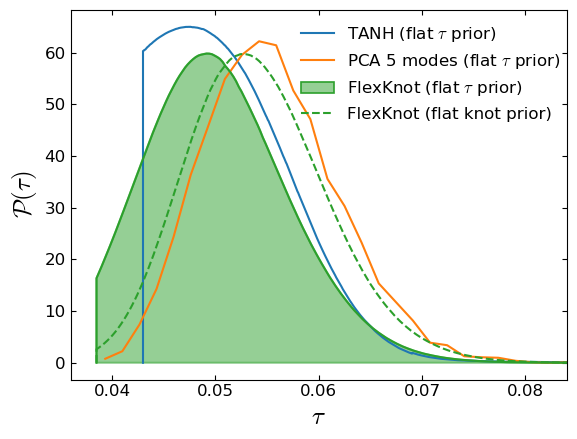

In [311]:
ctau_simall.like1d('cosmo.tau_out',ranges=(τmin_tanh_gp,None),zero_endpoints=True,c="C0",
                  label=r"TANH (flat $\tau$ prior)")

# flatτ(cmodes5_op_simall,Pτ_modes_op[5],maxweight=100).thin(10).like1d('cosmo.tau_out',c="C1",kde=False,
#                                                              label=r"PCA 5 modes (flat $\tau$ prior)")

cmodes5_op_simall.thin(10).like1d('cosmo.tau_out',c="C1",kde=False,
                                                             label=r"PCA 5 modes (flat $\tau$ prior)")


Chains(cflex_simall.values()).join().like1d("cosmo.tau_out",ranges=(τmin_gp,None),c="C2",zero_endpoints=True,ls="--",
                                           label=r"FlexKnot (flat knot prior)")

Chains(cflex_simall_flatτ.values()).join().like1d("cosmo.tau_out",ranges=(τmin_gp,None),color="C2",zero_endpoints=True,filled=0.5,
                                                  label=r"FlexKnot (flat $\tau$ prior)", lw=1.5)


handles, labels = gca().get_legend_handles_labels()
order = [0,1,3,2]
handles[3] = Patch(facecolor=(to_rgb("C2")+(0.5,)), edgecolor='C2', lw=1.2)
plt.legend([handles[i] for i in order],[labels[i] for i in order],loc=(0.45,0.68))


xlabel(r"$\tau$",size=18)
ylabel(r"$\mathcal{P}(\tau)$",size=18)

xlim(0.036,0.084)

savefig("plots/tau_simall_ee.pdf",bbox_inches='tight')

### get tau_15_30

In [171]:
sk = Slik(load_script('planck_reio3.py')[1](
    modesfile="mh_xepcs_raw.dat",model="reioflexknots2_fixclamp",nmodes=1,no_clik=True,only_lowp=True, auto_reject_errors=True,gpprior=True))
# sk.params.camb.zmin_cut=15

Removed no burn in
Removed no burn in


(3.068496165569223e-07, 0.015315432635314286)

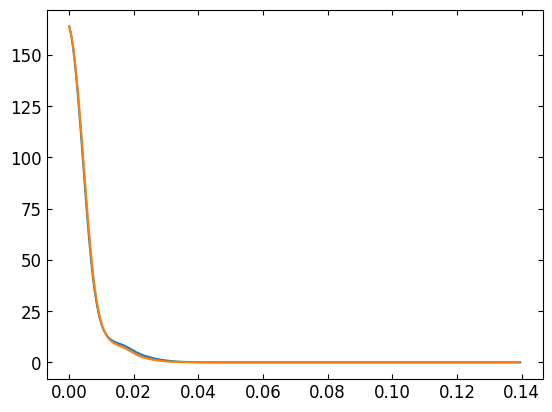

In [263]:
Chains(cflex_simlow.values()).join().like1d("cosmo.tau15", ranges=(0,None))
Chains(cflex_simlow_flatτ15.values()).join().like1d("cosmo.tau15", ranges=(0,None))
Chains(cflex_simlow_flatτ15.values()).join().confbound("cosmo.tau15", 0.95)

In [ ]:
with open("taupriors/reioflexknots_nmodes%i.dat"%i,"wb") as f:
    pickle.dump(Pτ,f)

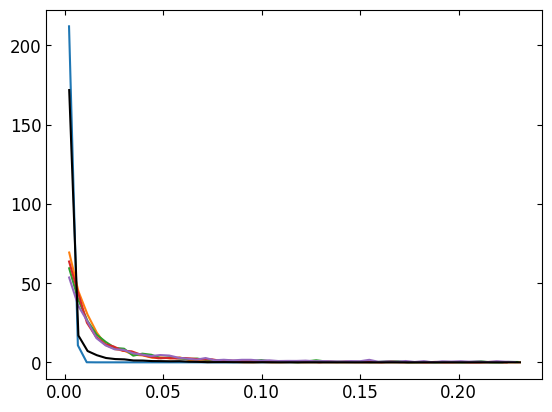

In [258]:
for c in cflex_simall_pp.values():
    c.like1d("cosmo.tau15",kde=False, nbins=50)
    
Chains(cflex_simall_pp.values()).join().like1d("cosmo.tau15",kde=False, nbins=50, c="k")

In [293]:
Chains(cflex_simlow.values()).join().confbound("cosmo.tau15",0.95)

(3.068496165569223e-07, 0.0170877692578761)

In [318]:
Chains(cflex_simlow_flatτ15.values()).join().confbound("cosmo.tau15",0.95)

(3.068496165569223e-07, 0.015315432635314286)

In [294]:
Chains(cflex_simall_pp.values()).join().confbound("cosmo.tau15",0.95)

(1.6426802651968465e-06, 0.023999585949801897)

In [297]:
cflex_simall_pp_flatτ15[2].join().confbound("cosmo.tau15",0.95)

(3.6527298390613143e-06, 0.04478465809966623)

In [296]:
cflex_simall_pp_flatτ15[1].join().confbound("cosmo.tau15",0.95)

(4.148017652194241e-06, 0.004431641029205323)

In [295]:
Chains(cflex_simall_pp_flatτ15.values()).join().confbound("cosmo.tau15",0.95)

(1.6426802651968465e-06, 0.02156154515869217)

/home/marius/work/cosmoslik/cosmoslik/chains.py:478: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  H, xe = histogram(dat,bins=nbins,weights=weights,normed=True,range=ranges)
/home/marius/work/cosmoslik/cosmoslik/chains.py:479: MatplotlibDeprecationWarning: The movavg function was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  xem=movavg(xe,2)


(1.6426802651968465e-06, 0.0030534186748665077)

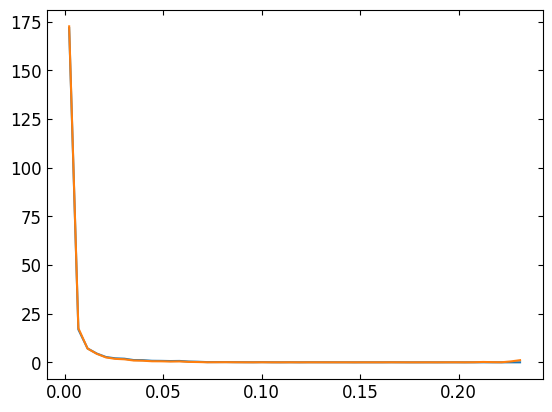

In [266]:
Chains(cflex_simall_pp.values()).join().like1d("cosmo.tau15",kde=False, nbins=50)
Chains(cflex_simall_pp_flatτ15.values()).join().like1d("cosmo.tau15",kde=False, nbins=50)

Chains(cflex_simall_pp.values()).join().confbound("cosmo.tau15",0.68)

In [247]:
cflex_simall_pp = {i: cflex_simall[i].postprocd(lambda **kw: {"cosmo.tau15": sk.evaluate(**kw)[1].camb.results.get_tau(15,30)}) 
                   for i in cflex_simall.keys()}

In [254]:
# with open("polychord/reioflexknots2_fixclamp_nmodes1to5_onlylowp_simall_EE_gpprior_pptau15","wb") as f:
#     pickle.dump(cflex_simall_pp, f)

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


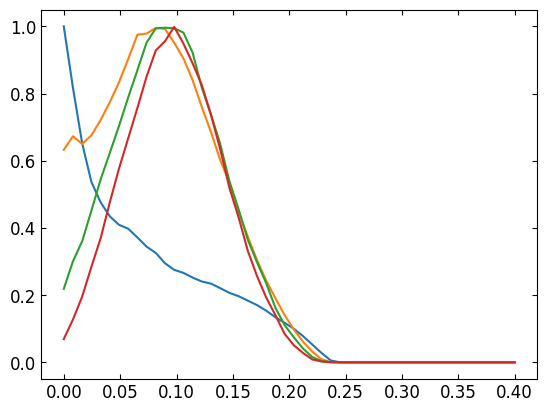

In [314]:
for i in range(1,5):
    plot(linspace(0,0.4), list(map(getτprior(cflex_noclik[i],k="cosmo.tau15_out",ranges=(0,None)), linspace(0,0.4))))

In [265]:
cflex_simall_pp_flatτ15 = {i: flatτ(cflex_simall_pp[i], getτprior(cflex_noclik[i],k="cosmo.tau15_out",ranges=(0,None)), maxweight=10000, k="cosmo.tau15") for i in cflex_simall_pp}

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


## CVL

In [95]:
cmodes_op_cvl = load_chain("chains/chain_reiomodes_fixclamp_nmodes5_onlylowp_cvlowp_mh_xepcs_raw_mhprior_mhfid_mhfidbase054").burnin(1000).join().thin(5)
ctau_cvl = load_chain("chains/chain_reiotanh_fixclamp_onlylowp_cvlowp").burnin(1000).join().thin(5)

In [96]:
cmodes_simlowlike_op = load_chain("chains/chain_reiomodes_fixclamp_nmodes5_onlylowp_simlowlike_mh_xepcs_raw_mhprior_mhfid_mhfidbase054").burnin(1000).join().thin(5)
ctau_simlowlike = load_chain("chains/chain_reiotanh_fixclamp_onlylowp_simlowlike").burnin(1000).join().thin(5)

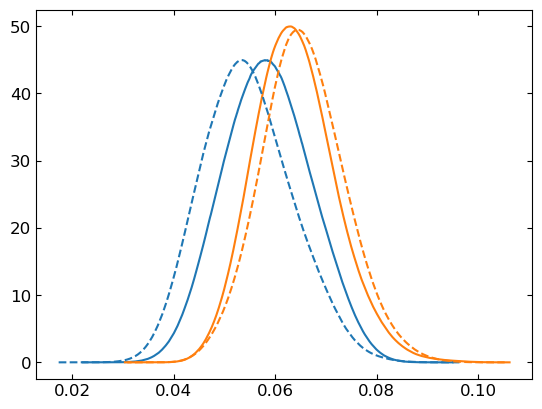

In [103]:
ctau_simlowlike.like1d("cosmo.tau_out",maxed=False,c="C0")
cmodes_simlowlike_op.like1d("cosmo.tau_out",maxed=False,c="C1")

ctau_simlow.like1d('cosmo.tau_out',maxed=False,c="C0",ls="--")
cmodes5_simlow_op.like1d('cosmo.tau_out',maxed=False,c="C1",ls="--")

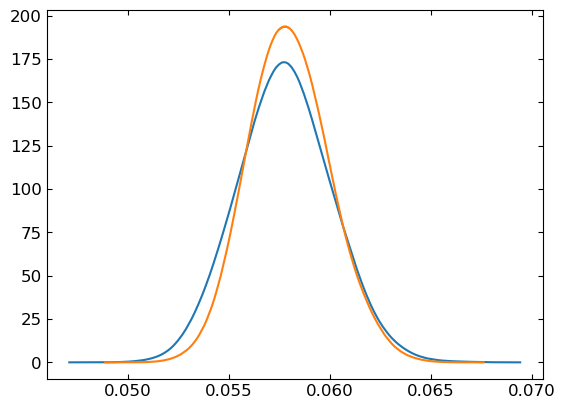

In [106]:
cmodes_op_cvl.like1d('cosmo.tau_out',maxed=False)
ctau_cvl.like1d('cosmo.tau_out',maxed=False)

In [97]:
cmodes_op_cvl.std('cosmo.tau_out'), ctau_cvl.std('cosmo.tau_out')

(0.0023496570045322077, 0.0020411172635358414)

In [98]:
cmodes_op_cvl.std('cosmo.tau_out') / ctau_cvl.std('cosmo.tau_out')

1.1511621828438612

In [99]:
cmodes5_simlow_op.std('cosmo.tau_out') / ctau_simlow.sample(ctau_simlow['cosmo.tau_out']>0.048).std('cosmo.tau_out')

1.1899260973059673

In [103]:
(flatτ(cmodes_op_cvl, cmodes_op_noclik[5]).mean('cosmo.tau_out') - cmodes_op_cvl.mean('cosmo.tau_out')) / cmodes_op_cvl.std('cosmo.tau_out')

-0.20452504598115029

## Scratch

In [35]:
pmodes_simlow_flatτ = {i:postτ(load_cosmomc_chain(
    "polychord/reiomodes_fixclamp_nmodes%i_onlylowp_simlow_mhprior_mhfid_mh_xepcs_raw_undo_mh_xepcs_nmodes%i_hardxe100200.txt"%(i,i),
    paramnames=['weight','lnl']+['cosmo.reiomodes.mode%i'%i for i in range(5)])) for i in range(1,7)}

NameError: name 'postτ' is not defined

In [ ]:
cmodes5_simlow["cosmo.tau_out2"] = cmodes5_simlow["cosmo.tau_out"]

In [257]:
postτ(cmodes5_simlow)

               # of steps:  227697
             total weight:  253821.00
               acceptance:  0.897
                 cosmo.H0:       66.81 ± 2.842e-14
    cosmo.reiomodes.mode0:     -0.0732 ± 0.03507
    cosmo.reiomodes.mode1:     0.07232 ± 0.09708
    cosmo.reiomodes.mode2:       0.076 ± 0.2395
    cosmo.reiomodes.mode3:    -0.06589 ± 0.2111
    cosmo.reiomodes.mode4:     0.01411 ± 0.199
            cosmo.tau_out:     0.03075 ± 0.009604
           cosmo.tau_out2:     0.06054 ± 0.009588
               lnls.highl:           0 ± 0
      lnls.inv_mode_prior:           0 ± 0
               lnls.lowlP:      -49.75 ± 1.068
               lnls.lowlT:           0 ± 0

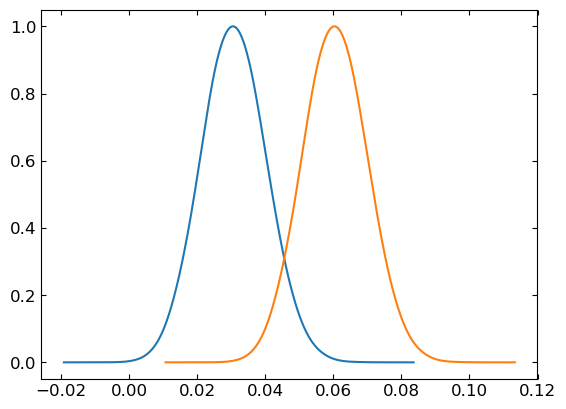

In [258]:
cmodes5_simlow.like1d("cosmo.tau_out")
cmodes5_simlow.like1d("cosmo.tau_out2")

In [246]:
ls chains/*simlow*

chains/chain_reioknots_fixclamp_knots_6_7.5_10_20_onlylowp_simlow_gpprior_reiotau_xepcs_v3
chains/chain_reioknots_fixclamp_onlylowp_simlow_reiotau_xepcs_v3
chains/chain_reiomodes_fixclamp_nmodes3_onlylowp_simlow_mhprior_mhfid_mh_xepcs_raw_undo_mh_xepcs_nmodes3_hardxe100200
chains/chain_reiomodes_fixclamp_nmodes5_onlylowp_simlow_mhprior_mhfid_mh_xepcs_raw_hardxe100200
chains/chain_tau_fixclamp_onlylowp_simlow_reiotau_xepcs_v3


In [240]:
pmodes_simlow_flatτ = {i:postτ(load_cosmomc_chain(
    "polychord/reiomodes_fixclamp_nmodes%i_onlylowp_simlow_mhprior_mhfid_mh_xepcs_raw_undo_mh_xepcs_nmodes%i_hardxe100200.txt"%(i,i),
    paramnames=['weight','lnl']+['cosmo.reiomodes.mode%i'%i for i in range(5)])) for i in range(1,7)}

In [244]:
pmodes_bflike_flatτ = {i:postτ(load_cosmomc_chain(
    "polychord/reiomodes_fixclamp_nmodes%i_onlylowp_bflike_mhprior_mhfid_mh_xepcs_raw_undo_mh_xepcs_nmodes%i_hardxe100200.txt"%(i,i),
    paramnames=['weight','lnl']+['cosmo.reiomodes.mode%i'%i for i in range(5)])) for i in range(1,7)}

(0, 0.07)

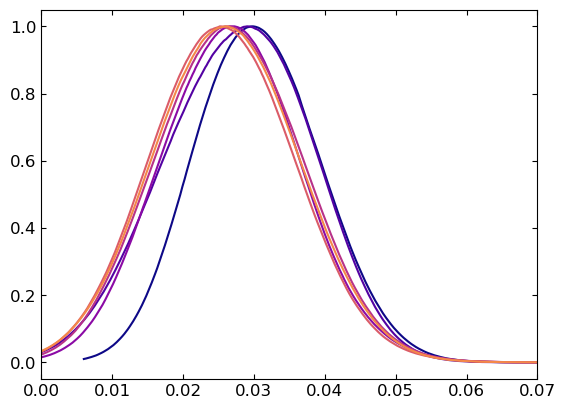

In [243]:
for i in range(1,7):
    pmodes_simlow_flatτ[i].like1d("cosmo.tau_out",c=get_cmap("plasma",8)(i-1),label="%i PCA modes"%i)
xlim(0,0.07)

(0, 0.07)

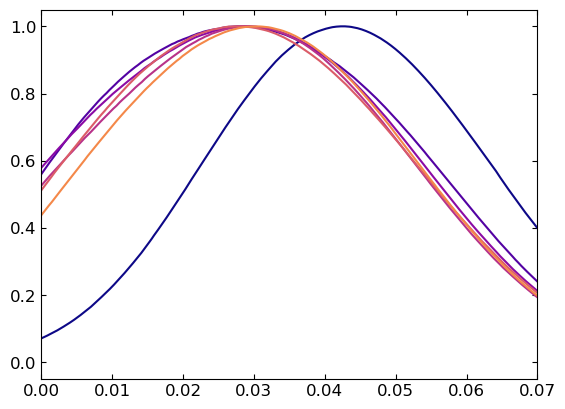

In [245]:
for i in range(1,7):
    pmodes_bflike_flatτ[i].like1d("cosmo.tau_out",c=get_cmap("plasma",8)(i-1),label="%i PCA modes"%i)
xlim(0,0.07)

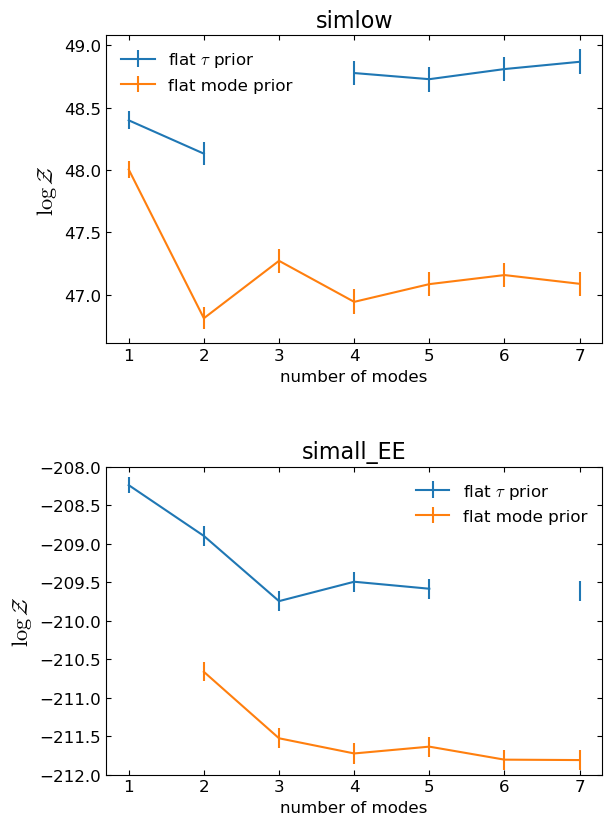

In [87]:
figure(figsize=(6.4,4.8*2))
subplots_adjust(hspace=0.4)
subplot(211)

errorbar(range(1,8),*transpose([getZ("polychord/reiomodes_fixclamp_nmodes%i_onlylowp_simlow_mhprior_mhfid_mh_xepcs_raw_undo_mh_xepcs_nmodes%i_hardxe100200.stats"%(i,i)) for i in range(1,8)]))
errorbar(range(1,8),*transpose([getZ("polychord/reiomodes_fixclamp_nmodes%i_onlylowp_simlow_mhprior_mhfid_mh_xepcs_raw_hardxe100200.stats"%i) for i in range(1,8)]))
ylabel(r'$\log\, \mathcal{Z}$')
xlabel('number of modes',size=12)
legend([r'flat $\tau$ prior','flat mode prior'])
title('simlow')
subplot(212)

errorbar(range(1,8),*transpose([getZ("polychord/reiomodes_fixclamp_nmodes%i_onlylowp_simall_EE_mhprior_mhfid_mh_xepcs_raw_undo_mh_xepcs_nmodes%i_hardxe100200.stats"%(i,i)) for i in range(1,8)]))
errorbar(range(1,8),*transpose([getZ("polychord/reiomodes_fixclamp_nmodes%i_onlylowp_simall_EE_mhprior_mhfid_mh_xepcs_raw_hardxe100200.stats"%i) for i in range(1,8)]))
ylim(-212,-208)
legend([r'flat $\tau$ prior','flat mode prior'])
ylabel(r'$\log\, \mathcal{Z}$')
xlabel('number of modes',size=12)
title('simall_EE')

(0.7, 7.3)

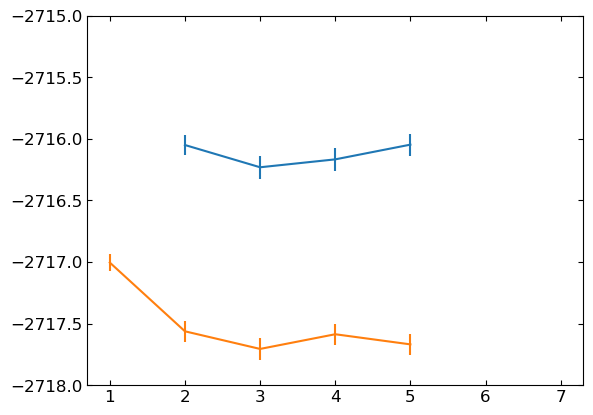

In [17]:
errorbar(range(1,7),*transpose([getZ("polychord/reiomodes_fixclamp_nmodes%i_onlylowp_bflike_mhprior_mhfid_mh_xepcs_raw_undo_mh_xepcs_nmodes%i_hardxe100200.stats"%(i,i)) for i in range(1,7)]))
ylim(-2718,-2715)

errorbar(range(1,7),*transpose([getZ("polychord/reiomodes_fixclamp_nmodes%i_onlylowp_bflike_mhprior_mhfid_mh_xepcs_raw_hardxe100200.stats"%i) for i in range(1,7)]))
ylim(-2718,-2715)

xlim(0.7,7.3)

In [13]:
cs = {i:load_cosmomc_chain("polychord/reiomodes_fixclamp_nmodes%i_onlylowp_bflike_mhprior_mhfid_mh_xepcs_raw_hardxe100200.txt"%i) for i in range(1,7)}

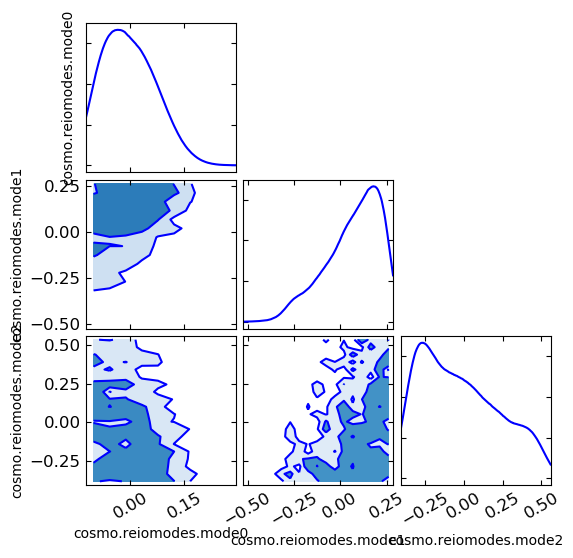

In [6]:
cs[3].likegrid()

## For Planck paper

### With GP

In [33]:
cknots_simall = load_chain("chains/chain_reioknots_fixclamp_knots_6_7.5_10_20_onlylowp_simall_EE_gpprior_reiotau_xepcs_v3").burnin(3000).join()
cknots_simall_flatτ = flatτ(cknots_simall,cknots_noclik)
cmodes_simall = load_chain("chains/chain_reiomodes_fixclamp_nmodes5_onlylowp_simall_EE_mhprior_mhfid_mh_xepcs_raw_hardxe100200").burnin(2000).join()
cmodes_simall_flatτ = flatτ(cmodes_simall,cmodes_noclik[5])
ctau_simall = load_chain("chains/chain_tau_fixclamp_onlylowp_simall_EE_reiotau_xepcs_v3").burnin(1000).join()

FileNotFoundError: [Errno 2] No such file or directory: 'chains/chain_reioknots_fixclamp_knots_6_7.5_10_20_onlylowp_simall_EE_gpprior_reiotau_xepcs_v3'

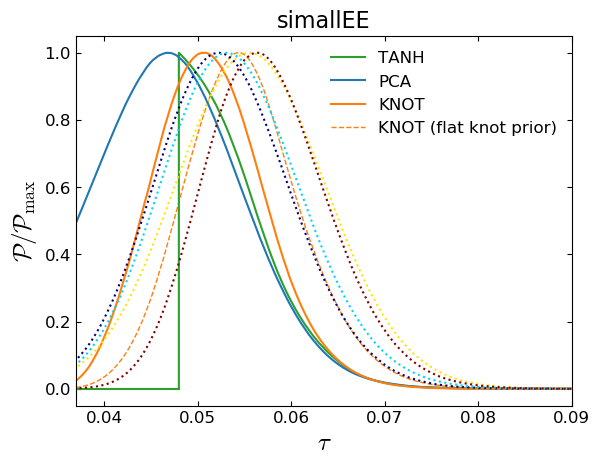

In [10]:
ctau_simall.sample(ctau_simall["cosmo.tau_out"]>0.048).like1d("cosmo.tau_out",ranges=(0.048,None),zero_endpoints=True,c='C2',label='TANH')
plot([0,0.048],[0]*2,c="C2")

cmodes_simall_flatτ.sample(cmodes_simall_flatτ["cosmo.tau_out"]>0.037).like1d("cosmo.tau_out",ranges=(0.037,None),zero_endpoints=True,c='C0',label='PCA')
cknots_simall_flatτ.like1d("cosmo.tau_out",c='C1',label='KNOT')
cknots_simall.like1d("cosmo.tau_out",c="C1",ls="--",lw=1,zorder=-1,label='KNOT (flat knot prior)')



xlim(0.037,0.09)

xlabel(r"$\tau$",size=18)
ylabel(r"$\mathcal{P} / \mathcal{P}_{\rm max}$",size=18)
title("simallEE")

legend()

# savefig('plots/tau_simall_ee.pdf',bbox_inches='tight')

(0, 0.1)

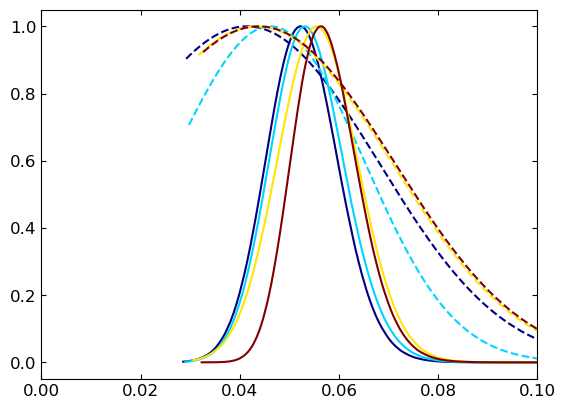

In [15]:
for i,c in cflex.items():
    c.like1d("cosmo.tau_out",c=get_cmap("jet",len(cflex))(i-2))
    flatτ(c,cflexknots_noclik[i]).like1d("cosmo.tau_out",c=get_cmap("jet",len(cflex))(i-2),ls="--")
xlim(0,0.1)

In [9]:
cflex = {i:load_cosmomc_chain("polychord/reioflexknots_fixclamp_nmodes%i_onlylowp_simall_EE_gpprior_reiotau_xepcs_v3.txt"%i) for i in range(2,6)}

In [21]:
{i:getZ("polychord/reioflexknots_fixclamp_nmodes%i_onlylowp_simall_EE_gpprior_reiotau_xepcs_v3.stats"%i) for i in range(2,6)}

{2: array([ -2.01987130e+02,   1.09935530e-01]),
 3: array([ -2.02341740e+02,   1.14674440e-01]),
 4: array([ -2.03286010e+02,   1.24771570e-01]),
 5: array([ -2.04387940e+02,   1.36212620e-01])}

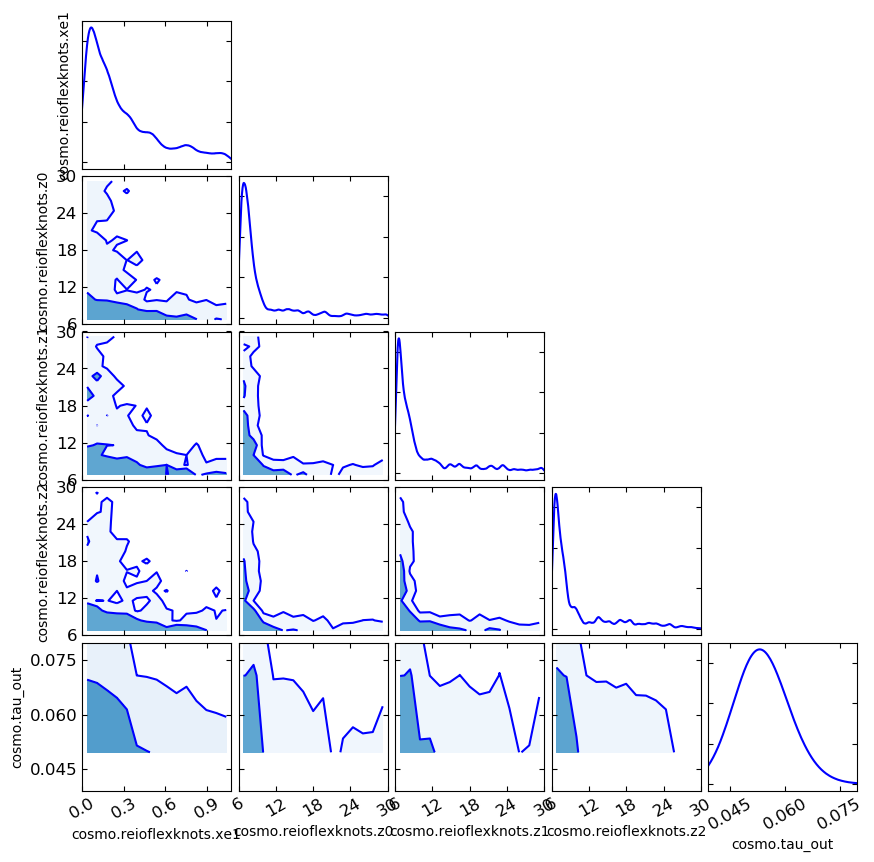

In [30]:
cflex[3].likegrid(nbins2d=15)

<Container object of 3 artists>

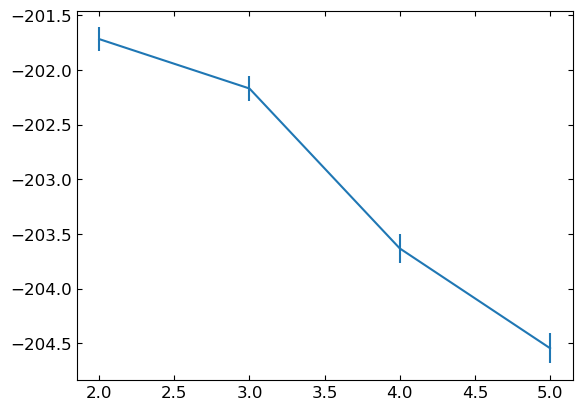

In [85]:
errorbar(range(2,6),*transpose([getZ("polychord/reioflexknots_fixclamp_nmodes%i_onlylowp_simall_EE_gpprior_reiotau_xepcs_v3.stats"%i) for i in range(2,6)]))

### Mode table

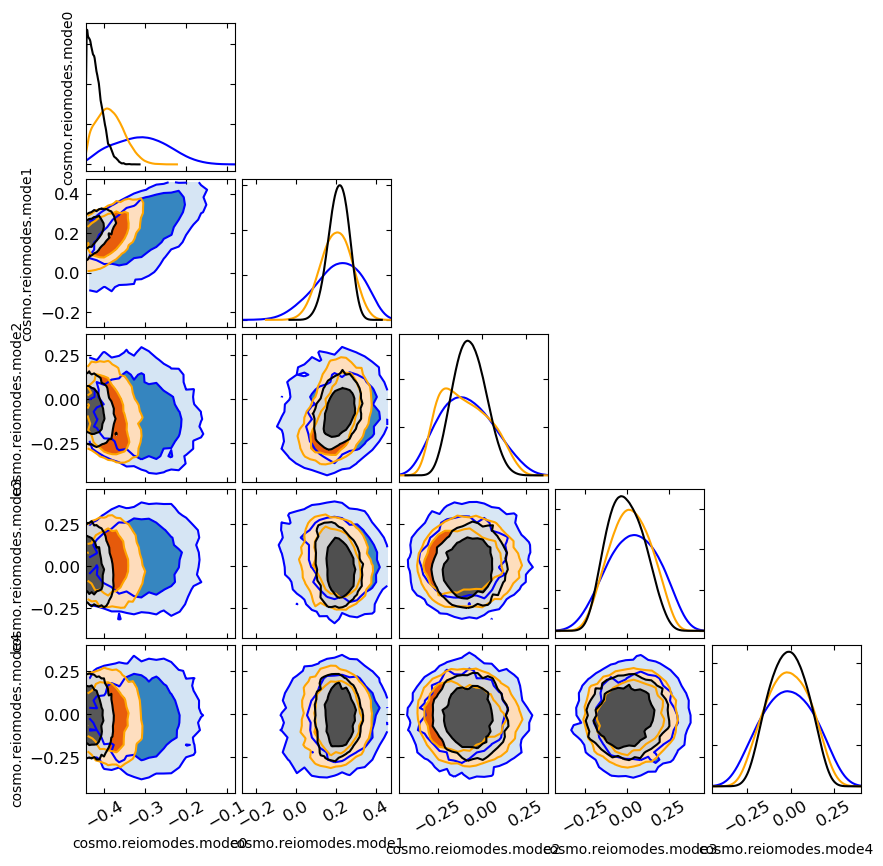

In [71]:
likegrid([cmodes5_bflike_op,cmodes5_simlow_op,cmodes5_op_simall], params=["cosmo.reiomodes.mode%i"%i for i in range(5)])

In [73]:
import pandas
ps = ['cosmo.reiomodes.mode%i'%i for i in range(5)]
print(pandas.DataFrame(vstack([cmodes5_op_simall.mean(ps), cmodes5_op_simall.std(ps),cmodes5_op_simall.corr(ps)]).T).to_latex(formatters=[lambda x: '%.2f'%x]*7))

\begin{tabular}{lrrrrrrr}
\toprule
{} &     0 &    1 &     2 &     3 &     4 &     5 &     6 \\
\midrule
0 & -0.42 & 0.02 &  1.00 &  0.35 & -0.18 & -0.15 & -0.09 \\
1 &  0.21 & 0.05 &  0.35 &  1.00 &  0.27 & -0.16 &  0.02 \\
2 & -0.07 & 0.09 & -0.18 &  0.27 &  1.00 &  0.09 & -0.03 \\
3 & -0.01 & 0.11 & -0.15 & -0.16 &  0.09 &  1.00 &  0.08 \\
4 & -0.01 & 0.11 & -0.09 &  0.02 & -0.03 &  0.08 &  1.00 \\
\bottomrule
\end{tabular}



### Without GP

In [261]:
cknots_nogp_simall = load_chain("chains/chain_reioknots_fixclamp_knots_2_4_6_7.5_10_20_onlylowp_simall_EE_reiotau_xepcs_v3").burnin(2000).join()

In [260]:
cknots_nogp_noclik = load_chain("chains/chain_reioknots_fixclamp_knots_2_4_6_7.5_10_20_noclik_reiotau_xepcs_v3").burnin(2000).join()

In [262]:
cknots_nogp_simall_flatτ = flatτ(cknots_nogp_simall, cknots_nogp_noclik)

In [14]:
cmodes_nogp_simall = {i:load_chain("chains/chain_reiomodes_fixclamp_nmodes%i_onlylowp_simall_EE_mhprior_mhfid_mh_xepcs_zmin1.5_mhnorm_hardxe100200"%i).burnin(3000).join() for i in range(1,8)}

In [57]:
cmodes_nogp_noclik = {i:load_chain("chains/chain_reiomodes_fixclamp_nmodes%i_noclik_mhprior_mhfid_mh_xepcs_zmin1.5_mhnorm_hardxe100200"%i).burnin(3000).join() for i in [1,2,3,4,5,6,7]}

In [269]:
cmodes_nogp_simall_flatτ = flatτ(cmodes_nogp_simall[5],cmodes_nogp_noclik[5])

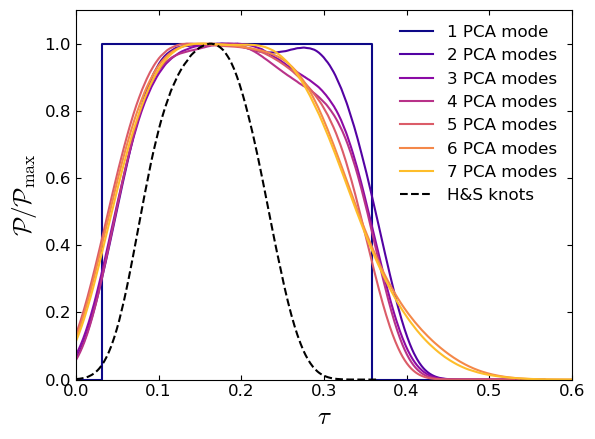

In [58]:
plot(hstack([0,[cmodes_nogp_noclik[1]['cosmo.tau_out'].min()]*2,[cmodes_nogp_noclik[1]['cosmo.tau_out'].max()]*2,0.6]),[0,0,1,1,0,0],c=get_cmap("plasma",8)(0),label='1 PCA mode')
for i in sorted(cmodes_nogp_noclik.keys())[1:]:
    cmodes_nogp_noclik[i].like1d("cosmo.tau_out",c=get_cmap("plasma",8)(i-1),label="%i PCA modes"%i)
ylim(0,1.1)
xlim(0,0.6)
cknots_nogp_noclik.like1d("cosmo.tau_out",c="k",label="H&S knots",ls="--")
legend()
xlabel(r"$\tau$",size=18)
ylabel(r"$\mathcal{P} / \mathcal{P}_{\rm max}$",size=18)

savefig("plots/implicit_priors.pdf",bbox_inches="tight")

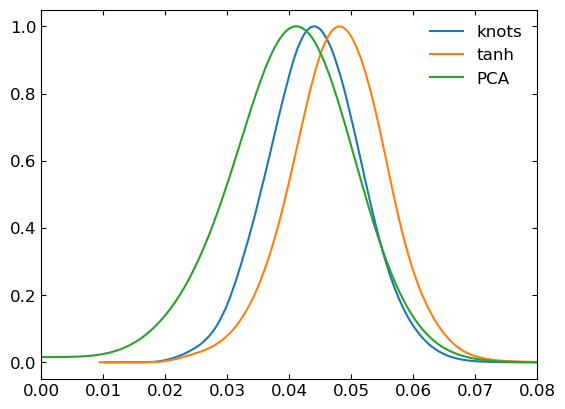

In [272]:
cknots_nogp_simall_flatτ.like1d("cosmo.tau_out")
ctau_simall.like1d("cosmo.tau_out")
cmodes_nogp_simall_flatτ.like1d("cosmo.tau_out")
xlim(0,0.08)
legend(['knots','tanh','PCA'])

In [59]:
# for i,c in cmodes_nogp_noclik.items():
#     with open('taupriors/mh_xepcs_zmin1.5_nmodes%i.dat'%i,'wb')as f:
#         pickle.dump(getτprior(c),f)

In [81]:
ls polychord/*simall*1.5*stats

polychord/reiomodes_fixclamp_nmodes1_onlylowp_simall_EE_mhprior_mhfid_mh_xepcs_raw_undo_mh_xepcs_zmin1.5_nmodes1_hardxe100200.stats
polychord/reiomodes_fixclamp_nmodes1_onlylowp_simall_EE_mhprior_mhfid_mh_xepcs_zmin1.5_mhnorm_hardxe100200.stats
polychord/reiomodes_fixclamp_nmodes2_onlylowp_simall_EE_mhprior_mhfid_mh_xepcs_raw_undo_mh_xepcs_zmin1.5_nmodes2_hardxe100200.stats
polychord/reiomodes_fixclamp_nmodes2_onlylowp_simall_EE_mhprior_mhfid_mh_xepcs_zmin1.5_mhnorm_hardxe100200.stats
polychord/reiomodes_fixclamp_nmodes3_onlylowp_simall_EE_mhprior_mhfid_mh_xepcs_raw_undo_mh_xepcs_zmin1.5_nmodes3_hardxe100200.stats
polychord/reiomodes_fixclamp_nmodes3_onlylowp_simall_EE_mhprior_mhfid_mh_xepcs_zmin1.5_mhnorm_hardxe100200.stats
polychord/reiomodes_fixclamp_nmodes4_onlylowp_simall_EE_mhprior_mhfid_mh_xepcs_raw_undo_mh_xepcs_zmin1.5_nmodes4_hardxe100200.stats
polychord/reiomodes_fixclamp_nmodes4_onlylowp_simall_EE_mhprior_mhfid_mh_xepcs_zmin1.5_mhnorm_hardxe100200.stats
polychord/reiomodes_

(-213, -208)

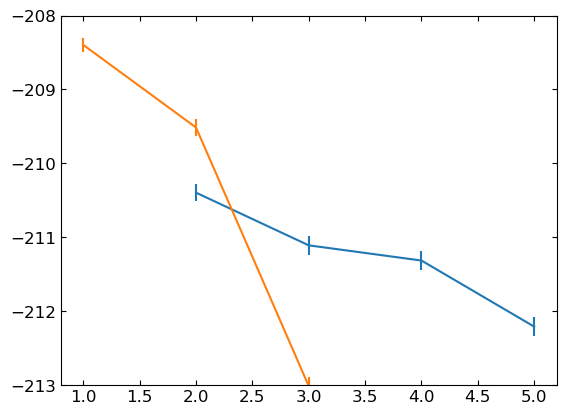

In [99]:
errorbar(range(1,6),*transpose([getZ("polychord/reiomodes_fixclamp_nmodes%i_onlylowp_simall_EE_mhprior_mhfid_mh_xepcs_zmin1.5_mhnorm_hardxe100200.stats"%i) for i in range(1,6)]))
errorbar(range(1,6),*transpose([getZ("polychord/reiomodes_fixclamp_nmodes%i_onlylowp_simall_EE_mhprior_mhfid_mh_xepcs_raw_undo_mh_xepcs_zmin1.5_nmodes%i_hardxe100200.stats"%(i,i),force=True) for i in range(1,6)]))
ylim(-213,-208)

In [ ]:
flatτ(cmodes_nogp_simall[5],cmodes5_nogp_noclik).like1d("cosmo.tau_out")

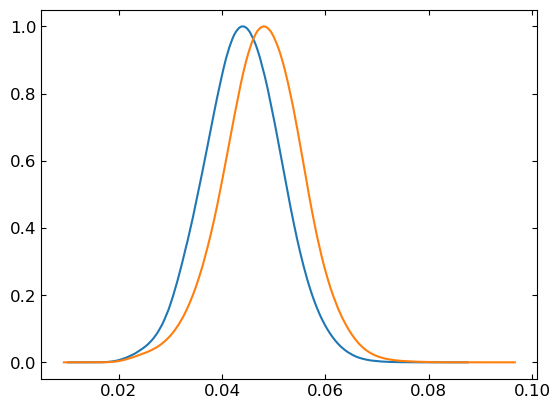

In [23]:
# cknots_nogp_simall.like1d("cosmo.tau_out",ls="--")
cknots_nogp_simall_flatτ.like1d("cosmo.tau_out")
ctau_simall.like1d("cosmo.tau_out")

## Histories

### Priors

In [125]:
n = 1000

In [126]:
# nmodes = 5
# sk = Slik(planck(model='reioflexknots_fixclamp',nmodes=nmodes,no_clik=True,only_lowp=True))
# cflexknots_noclik_thinto1000 = c = cflexknots_noclik[nmodes].thinto(n)
# c['camb.xe'] = array([sk.evaluate(**{k:s[k] for k in sk.get_sampled()})[1].camb.xe for s in c.iterrows()])

In [127]:
nmodes = 5
sk = Slik(planck(model='reioflexknots2_fixclamp',nmodes=nmodes,no_clik=True,only_lowp=True,gpprior=True))
xe_flexknots = [sk.evaluate(**dict({'cosmo.reioflexknots.z%i'%i:uniform(6,30) for i in range(nmodes)},
     **{'cosmo.reioflexknots.xe%i'%i:uniform(0,1.08) for i in range(nmodes)}))[1].camb.xe for i in range(1000)]

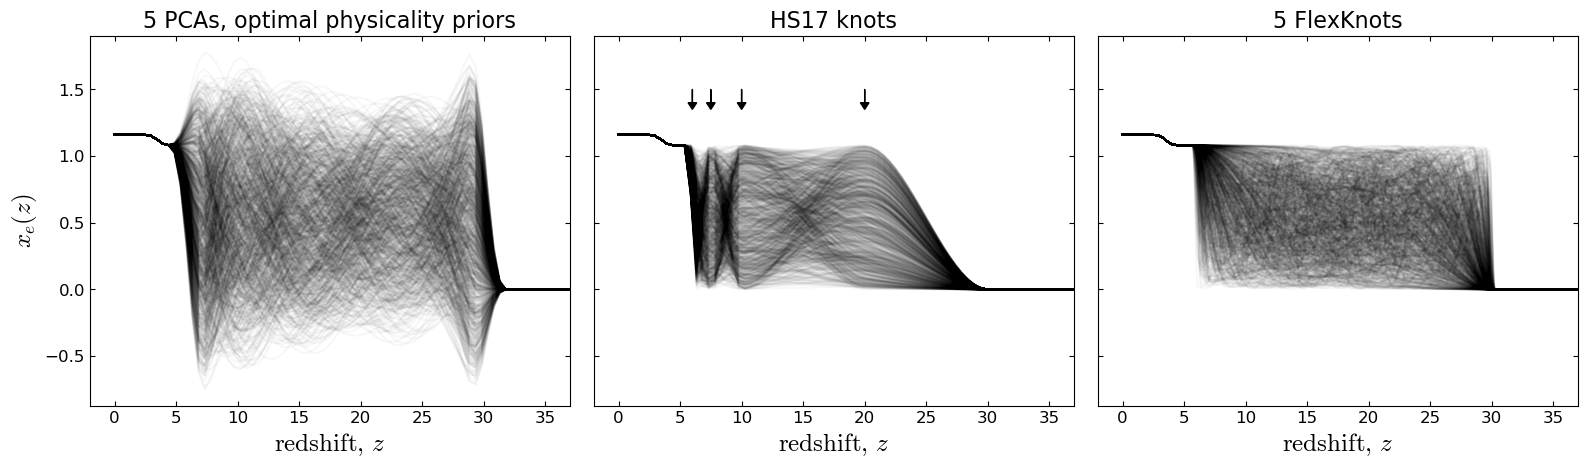

In [136]:
figure(figsize=(6.4*3,4.8))
subplots_adjust(wspace=0.05)

z = linspace(0,50,1024)
alpha = 0.03

ax=subplot(131)
gca().set_rasterization_zorder(1)
plot(z[::10],cmodes_op_noclik[5].thinto(n)["camb.xe_thin"].T,c="k",alpha=alpha,zorder=0);
title("5 PCAs, optimal physicality priors")
xlabel(r"${\rm redshift,}\,z$",size=18)
ylabel(r"$x_e(z)$",size=18)
y=ylim()

subplot(132,sharex=ax)
gca().set_rasterization_zorder(1)
plot(z[::10],cknots_noclik.thinto(n)["camb.xe_thin"].T,c="k",alpha=alpha,zorder=0);
title("HS17 knots")
xlabel(r"${\rm redshift,}\,z$",size=18)
gca().set_yticklabels([])
ylim(*y)
for x in [6,7.5,10,20]:
    arrow(x,1.5,0,-0.1,head_width=0.7,head_length=0.05,color="k")
# ylabel(r"$x_e(z)$",size=18)

subplot(133,sharex=ax)
gca().set_rasterization_zorder(1)
plot(z,transpose(xe_flexknots),c="k",alpha=alpha,zorder=0);
title("5 FlexKnots")
xlabel(r"${\rm redshift,}\,z$",size=18)
gca().set_yticklabels([])
ylim(*y)
# ylabel(r"$x_e(z)$",size=18)

xlim(-2,37)

savefig("plots/reio_hists_prior.pdf",bbox_inches="tight")

### Posteriors

In [22]:
from planck_reio3 import planck

In [26]:
# for i in [1,2,3,4,5]:
#     c = load_cosmomc_chain("polychord/reioflexknots2_fixclamp_nmodes%i_onlylowp_simall_EE_gpprior.txt"%i)
#     sk = Slik(planck(model="reioflexknots2_fixclamp",nmodes=i,only_lowp=True,no_clik=True,gpprior=True))
#     cpp = c.postprocd(lambda **s: {"xe":sk.evaluate(*[s[k] for k in sk.get_sampled()])[1].camb.xe})
#     with open("polychord/reioflexknots2_fixclamp_nmodes%i_onlylowp_simall_EE_gpprior_ppxe"%i,"wb") as f:
#         pickle.dump(cpp,f)
#     print(i)

In [27]:
# for i in [2,3,4,5]:
#     c = load_cosmomc_chain(
#         "polychord/reioflexknots_fixclamp_nmodes%i_onlylowp_simall_EE_gpprior_reiotau_xepcs_v3_undo_reioflexknots_nmodes%i.txt"%(i,i),
#         paramnames="polychord/reioflexknots_fixclamp_nmodes%i_onlylowp_simall_EE_gpprior_reiotau_xepcs_v3_undo_reioflexknots_nmodes%i.paramnames"%(i,i)
#     )
#     sk = Slik(planck(model="reioflexknots_fixclamp",nmodes=i,only_lowp=True,no_clik=True,gpprior=True))
#     cpp = c.postprocd(lambda **s: {"xe":sk.evaluate(*[s[k] for k in sk.get_sampled()])[1].camb.xe})
#     with open("polychord/reioflexknots_fixclamp_nmodes%i_onlylowp_simall_EE_gpprior_reiotau_xepcs_v3_undo_reioflexknots_nmodes%i_ppxe"%(i,i),"wb") as f:
#         pickle.dump(cpp,f)
#     print(i)

In [ ]:
cflex_simlow_xe = {i:load_chain("polychord/reioflexknots2_fixclamp_nmodes%i_onlylowp_simlow_gpprior_ppxe"%i) 
                               for i in range(1,6)}
for i,c in cflex_simlow_xe.items():
    c["weight"]/=(c["weight"].sum()*exp(-cflex_simlow[i].Z))

In [139]:
cflex_simlow_flatτ_xe = {i:flatτ(cflex_simlow_xe[i], cflex_noclik[i]) for i in range(1,6)}
for i,c in cflex_simlow_flatτ_xe.items():
    c['weight'] *= exp(-(-200-cflex_simlow[i].Z)) / sum(c['weight'])

In [23]:
cflex_simall_xe = {i:load_chain("polychord/reioflexknots2_fixclamp_nmodes%i_onlylowp_simall_EE_gpprior_ppxe"%i) 
                               for i in range(1,6)}
for i,c in cflex_simall_xe.items():
    c["weight"]/=(c["weight"].sum()*exp(-cflex_simall[i].Z))

In [24]:
cflex_simall_flatτ_xe = {i:flatτ(cflex_simall_xe[i], cflex_noclik[i]) for i in range(1,6)}
for i,c in cflex_simall_flatτ_xe.items():
    c['weight'] *= exp(-(-200-cflex_simall[i].Z)) / sum(c['weight'])

In [25]:
from wquantiles import quantile
def getint(dat,weights,p=0.95):
    return (quantile(dat,weights,(1-p)/2),quantile(dat,weights,(1-(1-p)/2)))

In [141]:
c = Chains(cflex_simlow_xe.values()).join()
lims_simlow = array([getint(c["xe"].T,c["weight"],p=p) for p in [0.68,0.95]]).swapaxes(1,2)

In [142]:
c = Chains(cflex_simlow_flatτ_xe.values()).join()
lims_simlow_flatτ = array([getint(c["xe"].T,c["weight"],p=p) for p in [0.68,0.95]]).swapaxes(1,2)

In [26]:
c = Chains(cflex_simall_xe.values()).join()
lims_simall = array([getint(c["xe"].T,c["weight"],p=p) for p in [0.68,0.95]]).swapaxes(1,2)
# np.save("xe_bounds_knot_v4.npy",lims_simall)

In [27]:
c = Chains(cflex_simall_flatτ_xe.values()).join()
lims_simall_flatτ = array([getint(c["xe"].T,c["weight"],p=p) for p in [0.68,0.95]]).swapaxes(1,2)

In [28]:
from planck_reio3 import pchip2_interpolate

In [29]:
c = ctau_simall#.thinto(3000)
c = c.sample(c["cosmo.tau_out"]>τmin_tanh_gp)
lims_tau = array([getint(c["camb.xe_thin"].T,c["weight"],p=p) for p in [0.68,0.95]]).swapaxes(1,2)
lims_tau = array([[pchip2_interpolate(linspace(0,50,1024)[::10],lims_tau[i,:,j],linspace(0,50,1024)) for i in range(2)] for j in range(2)]).swapaxes(1,2).swapaxes(0,2)

In [ ]:
for d in lims_simlow:
    fill_between(linspace(0,50,1024),*d.T,alpha=0.5,color="C0")
    
for d in lims_simlow_flatτ:
    for l in d.T:
        plot(linspace(0,50,1024),l,c='k')
#     fill_between(linspace(0,50,1024),*d.T,facecolor=to_rgb("C0")+(0.5,),edgecolor="C0")

# for d in lims_tau:
#     fill_between(linspace(0,50,1024),*d.T,facecolor=to_rgb("k")+(0.3,),edgecolor="k")
    
# for (lims,ls) in zip(lims_tau,["--",":"]):
#     for l in lims.T:
#         plot(linspace(0,50,1024),l,"k",ls=ls)

xlabel(r"${\rm redshift,}\; z$")
ylabel(r"$x_{\rm e}(z)$")
title(r"${\rm Planck \;2016} \;(\mathtt{simlow}$-$\rm only)$")

xlim(-2,32)
legend([Patch(facecolor=(to_rgb("C0")+(0.5,)), edgecolor='C0', lw=1.2),Patch(facecolor=(to_rgb("k")+(0,)), edgecolor='k', lw=1.2)],
       [r"FlexKnot (flat knot prior)",r"TANH (flat $\tau$ prior)"])
savefig("plots/reio_hists_simlow.pdf",bbox_inches='tight')

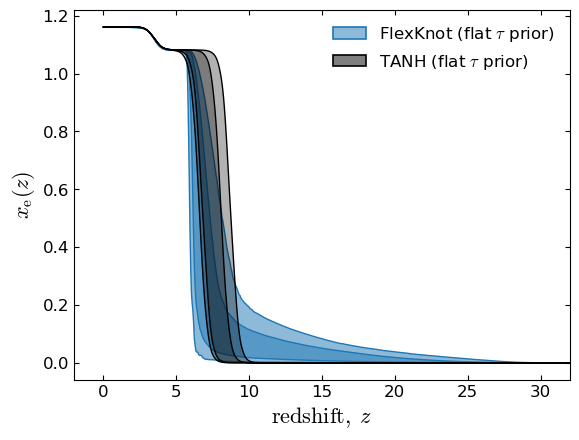

In [30]:
# for d in lims_simall:
#     fill_between(linspace(0,50,1024),*d.T,alpha=0.5,color="C0")
    
for d in lims_simall_flatτ:
    fill_between(linspace(0,50,1024),*d.T,facecolor=to_rgb("C0")+(0.5,),edgecolor="C0")


for d in lims_tau:
    fill_between(linspace(0,50,1024),*d.T,facecolor=to_rgb("k")+(0.3,),edgecolor="k")

    
# for (lims,ls) in zip(lims_tau,["--",":"]):
#     for l in lims.T:
#         plot(linspace(0,50,1024),l,"k",ls=ls)

xlabel(r"${\rm redshift,}\; z$")
ylabel(r"$x_{\rm e}(z)$")
xlim(-2,32)
legend([Patch(facecolor=(to_rgb("C0")+(0.5,)), edgecolor='C0', lw=1.2),Patch(facecolor=(to_rgb("k")+(0.5,)), edgecolor='k', lw=1.2)],
       [r"FlexKnot (flat $\tau$ prior)",r"TANH (flat $\tau$ prior)"])
savefig("plots/reio_hists_simall.pdf",bbox_inches='tight')